<h1>DCGAN - DEEP Convolutional GANs </h1>

#Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt #Para mostrar as imagens
import numpy as np #Para algumas operações matemáticas
import tensorflow as tf #Para trabalhar com a IA
from tensorflow.keras import layers #Para ter acesso às camadas convolucionais
tf.__version__

'2.18.0'

#Carregamento e pré-processamento da base de dados

In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_treinamento.shape #60 mil imagens com 28x28 pixels = 784 pixels

(60000, 28, 28)

In [4]:
y_treinamento.shape #o y traz as classes, se é 0, 1 etc

(60000,)

5


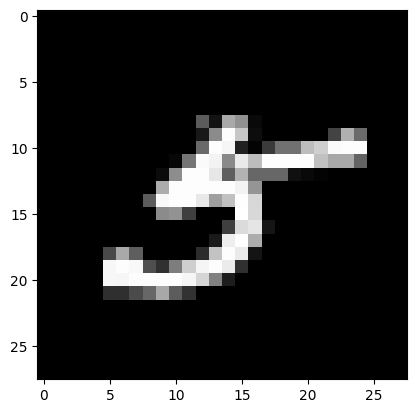

In [5]:
i = np.random.randint(0, 60000) #gera um inteiro aleatório
print(y_treinamento[i]) # mostra a classe
plt.imshow(X_treinamento[i], cmap = 'gray'); # ; remove the <message>

In [6]:
# 1 para gray scale, RGB seria 3 canais de input
# posicao 0 do x_treinamento traz a qntd de imagens
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')
X_treinamento.shape #novo shape

(60000, 28, 28, 1)

In [7]:
X_treinamento[0].min(), X_treinamento[0].max() # 0 preto, 255 branco

(np.float32(0.0), np.float32(255.0))

In [8]:
#para treinar, os valores devem estar em escala entre -1 e 1
X_treinamento = (X_treinamento - 127.5) / 127.5
X_treinamento[0].min(), X_treinamento[0].max()

(np.float32(-1.0), np.float32(1.0))

In [9]:
#Dividir a base de dados em batches de 256 imagens cada
#Mini batch gradient descent
#Vamos criar 234 batches de 256 imagens
buffer_size = 60000
batch_size = 256
buffer_size/batch_size

234.375

In [10]:
#precisamos converter o numpy array para o formato do tensorflow
display(type(X_treinamento))
# enviamos os dados do treinamento e fazemos o shuffle para evitar que a
# IA aprenda as imagens na ordem em que estão
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)
display(type(X_treinamento))
display(X_treinamento)

numpy.ndarray

tensorflow.python.data.ops.batch_op._BatchDataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Construção do Gerador

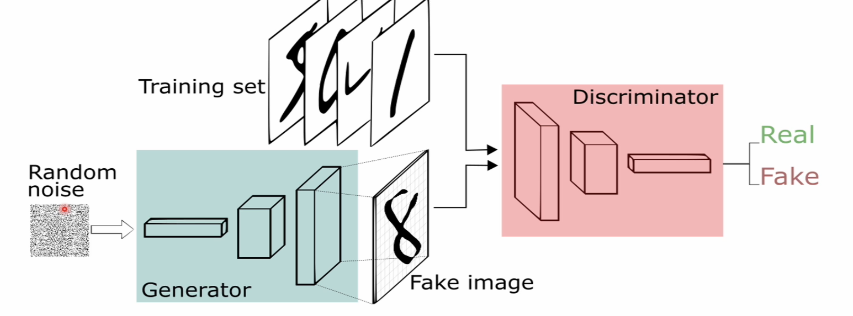

In [11]:
def cria_gerador():
    #classe do keras para construir redes neurais
    network = tf.keras.Sequential()

    #criando a primeira camada (densa pois todos os neuronios dessa camada
    #se liga aos neuronios da próxima camada) -> 12544 neuronios
    #a proxima camada de normalização, interessante utilizá-la para treinar redes
    #mais complexas. Leia no site da keras.io
    #Igual a ReLU mas o parametro alpha dá pesos aos valores negativos
    #estamos recebendo no formato de vetor e convertendo para o formato de matriz
    #pelo comando reshape
    network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Reshape((7,7,256)))

    #proxima camada 7x7x128, usando convolução
    #filters é o numero de kernels ou detectores de caracteristicas
    #O padding é o que decide se alguma parte da imagem será ignorada, ler no site
    network.add(layers.Conv2DTranspose(filters = 128,
                                       kernel_size = (5,5),
                                       padding = 'same',
                                       use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #nova camada 14x14x64, usando a convolução
    #stride indica de quantos em quantos pixels os calculos serão efetuados
    network.add(layers.Conv2DTranspose(filters = 64,
                                       kernel_size = (5,5),
                                       padding = 'same',
                                       use_bias = False,
                                       strides = (2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #ultima camada 28x28x1
    #usar a tanh como ativação pois configuramos os valores para ir de -1 a 1
    network.add(layers.Conv2DTranspose(filters = 1 ,
                                       kernel_size = (5,5,),
                                       use_bias = False,
                                       strides = (2,2),
                                       padding = 'same',
                                       activation = 'tanh'))
    network.summary()

    return network


In [12]:
gerador = cria_gerador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [13]:
#olhar a entrada dessa rede neural
# 100 -> 12544 -> se torna matriz até chegar a 28x28x1
gerador.inputs

[<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor>]

In [14]:
ruido = tf.random.normal([1,100]) #criar uma matriz com 100 valores
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-2.3103576 ,  1.6287707 ,  0.66030765,  1.2450742 ,  0.24694787,
         1.0720663 ,  0.61175185,  1.2340357 , -0.22874115,  0.6753165 ,
        -1.2546551 ,  0.7251476 ,  0.51526785, -1.4650975 , -0.50580955,
        -0.6290883 , -1.1457776 ,  1.9401984 ,  2.3984826 ,  1.5968574 ,
         0.4559361 ,  0.05221618, -0.02497842,  1.801329  ,  0.45779386,
         0.52943975, -1.0014472 , -0.67517406,  1.0014278 , -0.94333667,
        -0.08146363,  0.06353566,  0.10609491,  0.12324972,  0.6605533 ,
         0.07477394, -0.6828793 ,  0.7672336 , -0.96092004, -0.19476646,
         0.30484822,  0.40711692, -0.11897789, -1.5493561 ,  1.5025489 ,
         0.9394695 , -0.36654526, -1.0714471 , -0.52576226, -0.07835329,
        -1.2164294 , -1.3016248 , -0.06386141, -0.48921993,  0.70139855,
         0.9777958 ,  1.7588619 , -0.89264375,  1.5045397 ,  1.3907797 ,
         0.04840869,  0.5721923 , -0.39153856,  2.1691172 ,  0.03613159,
 

TensorShape([1, 28, 28, 1])

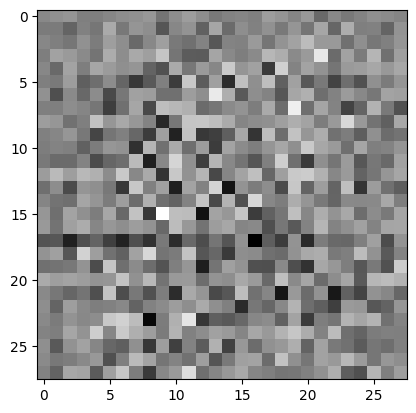

In [15]:
imagem_gerada = gerador(ruido, training = False) # antes do treinamento
display(imagem_gerada.shape) # o primeiro numero indica o Batch ou qntd de imagens
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

#Implementação do discriminador

In [16]:
def cria_discriminador():
    network = tf.keras.Sequential() # pois a network é uma sequencia de layers

    # 14x14x64
    #Conv2D para extrair caracteristicas, para detecção
    #Conv2Dtransposer é mais utilizado para deconvolução, como no gerador
    #Dropout para evitar o overfitting
    #input shape é usado somente na primeira camada indicando as entradas
    #Strides permite o calculo de 2 em 2 pixels
    network.add(layers.Conv2D(filters = 64,
                              strides = (2,2),
                              kernel_size = (5,5),
                              padding = 'same',
                              input_shape = [28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    # 7x7x128
    network.add(layers.Conv2D(filters = 128,
                              strides = (2,2),
                              kernel_size = (5,5),
                              padding = 'same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1)) # todo o vetor ligado ao neuronio de saída -> 0 - 1

    network.summary()

    return network


In [17]:
discriminador = cria_discriminador()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Reparando que é o contrário do gerador, que recebe um vetor de 100 números e constrói uma imagem de 28x28x1. No discriminador recebe-se uma imagem 28x28x1 e na saída tem-se um único valor.

In [18]:
discriminador.inputs

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_67>]

In [19]:
discriminador(imagem_gerada) #logits resultado bruto da rede neural
# é preciso fazer a ativação com alguma função, como sigmoid

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00224838]], dtype=float32)>

In [20]:
tf.sigmoid(0.00054448) # 50% de probabilidade sem treino

<tf.Tensor: shape=(), dtype=float32, numpy=0.500136137008667>

#Cálculo do erro

Logits https://deepai.org/machine-learning-glossary-and-terms/logit
Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações. Ele compara as previsões do discriminador em imagens reais com uma matriz de 1s e as previsões do discriminador em imagens falsas (geradas) com uma matriz de 0s.

In [21]:
#pacote que contem os calculso de loss
#passamos que o formato da resposta será de logits
#logits basicamente é o resultado bruto da rede neural sem nenhum tratamento
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)


In [22]:
#como as imagens reais é comparada com uma matriz de número 1, essa função
#retorna o numero 1
display(tf.ones_like(1))

#o mesmo com as fakes, mas com 0
display(tf.zeros_like(1))

<tf.Tensor: shape=(), dtype=int32, numpy=1>

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [23]:
def discriminador_loss(expected_output, fake_output):
    #cada imagem é comparada com o valor da matriz
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def gerador_loss(fake_output):
    #no gerador comparamos as imagens falsas com o numero 1,
    #que é a comparação das imagens reais, para tornar cada vez mais próximo de 1
    #as imagens fake
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

#Treinamento da GAN e visualização dos Resultados

In [28]:
display(X_treinamento)
display(batch_size,100)


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

256

100

In [29]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [30]:
@tf.function
def treinamento(imagens):
    #como tem 256 imagens por batch, precisar enviar 256 vetores de ruido (contendo 100 num)
    ruido = tf.random.normal([batch_size, dimensao_ruido])
    #gradiente indicando a direção que o peso será atualizado para ao gerador e discrim...
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        imagens_geradas = gerador(ruido, training = True)

        #numeros proximos de 1 nessa variavel
        expected_output = discriminador(imagens, training = True)
        #numeros proximos de 0 nessa variavel
        fake_output = discriminador(imagens_geradas, training = True)

        gen_loss = gerador_loss(fake_output) #tenta gerar imagens fakes proximas de 1 no discriminador
        disc_loss = discriminador_loss(expected_output, fake_output) # calcula loss tanto para fake distante de 0 como para real distante de 1

    # calcula o gradiente, indicando se o peso deve subir ou descer, etc
    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    #atualiza de fato os pesos
    #zip pois passa mais de uma variavel
    gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [37]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
display(imagens_teste.shape) #16 imagens, cada uma possui 100 valores aleatórios

TensorShape([16, 100])

In [38]:
def treina_gan(dataset, epocas, imagens_teste):
    for epoca in range(epocas):
        for imagem_batch in dataset:
            #print(imagem_batch.shape)
            treinamento(imagem_batch)
        print('Época: ', epoca + 1)

        #depois do treinamento com cada batch, vamos gerar imagens parciais com o gerador
        #ele já terá aprendido algo e não serão mais pesos aleatórios
        imagens_geradas = gerador(imagens_teste, training = False)
        fig = plt.figure(figsize = (10,10))

        for i in range(imagens_geradas.shape[0]):#16 vezes
            plt.subplot(4,4, i+1) # forma de dispor e o id da imagem
            #os pixels estão entre -1 e 1, precisamos desnormalizar
            plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
            plt.axis('off')
        plt.show()

Época:  1


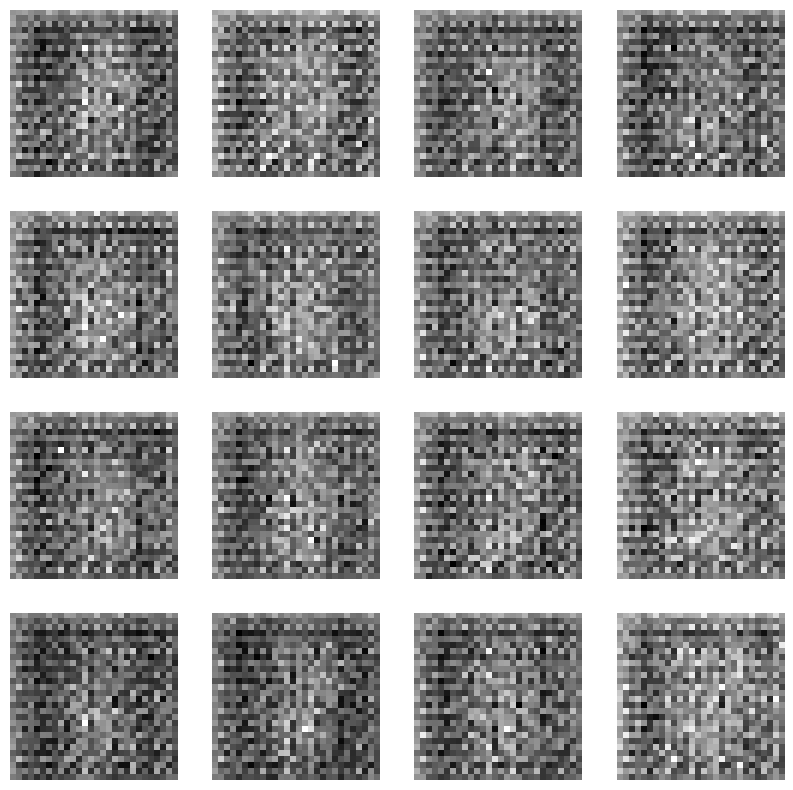

Época:  2


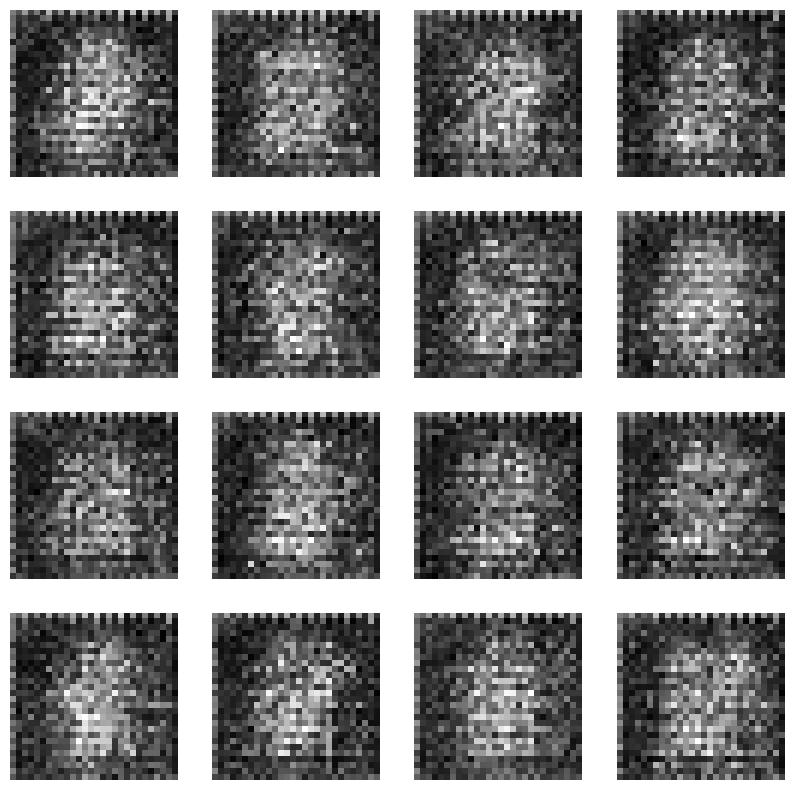

Época:  3


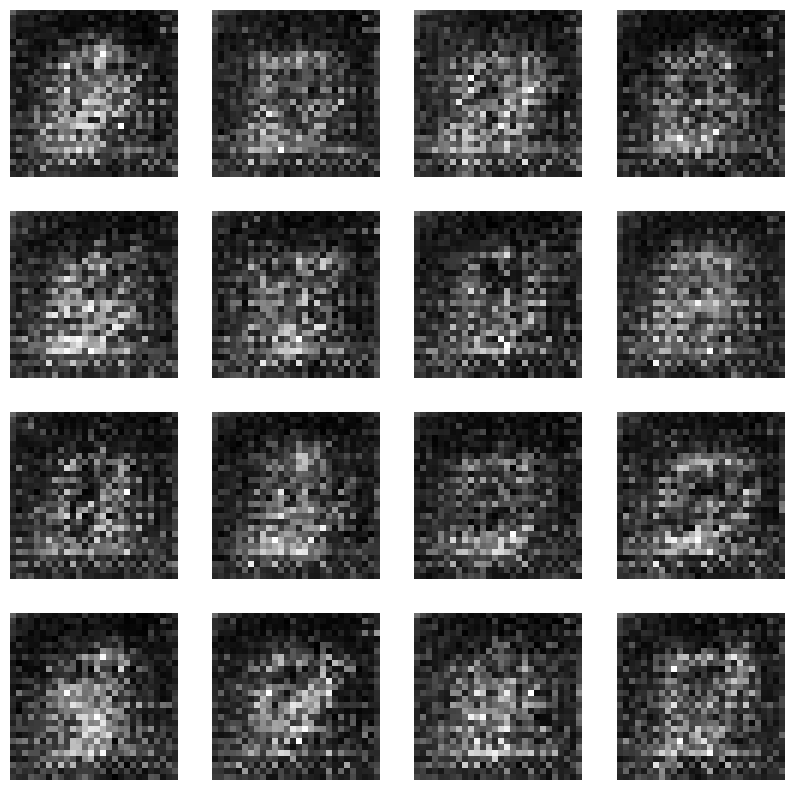

Época:  4


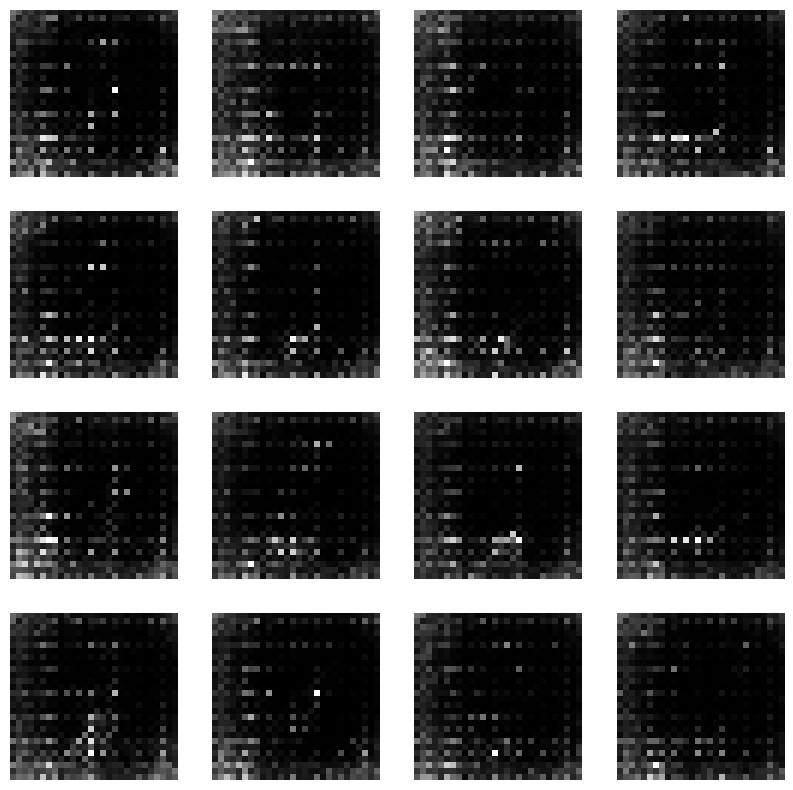

Época:  5


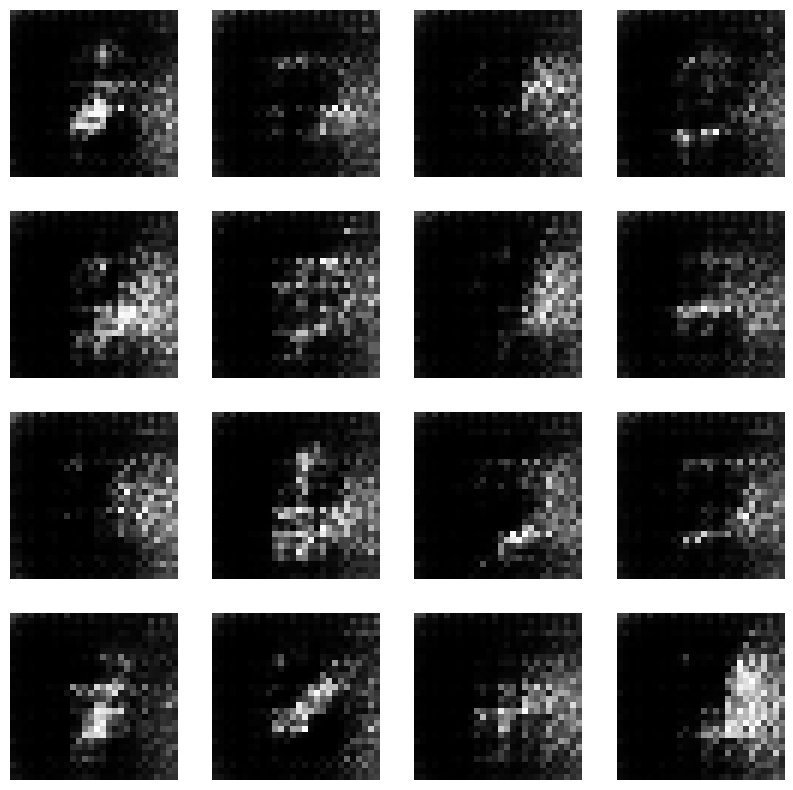

Época:  6


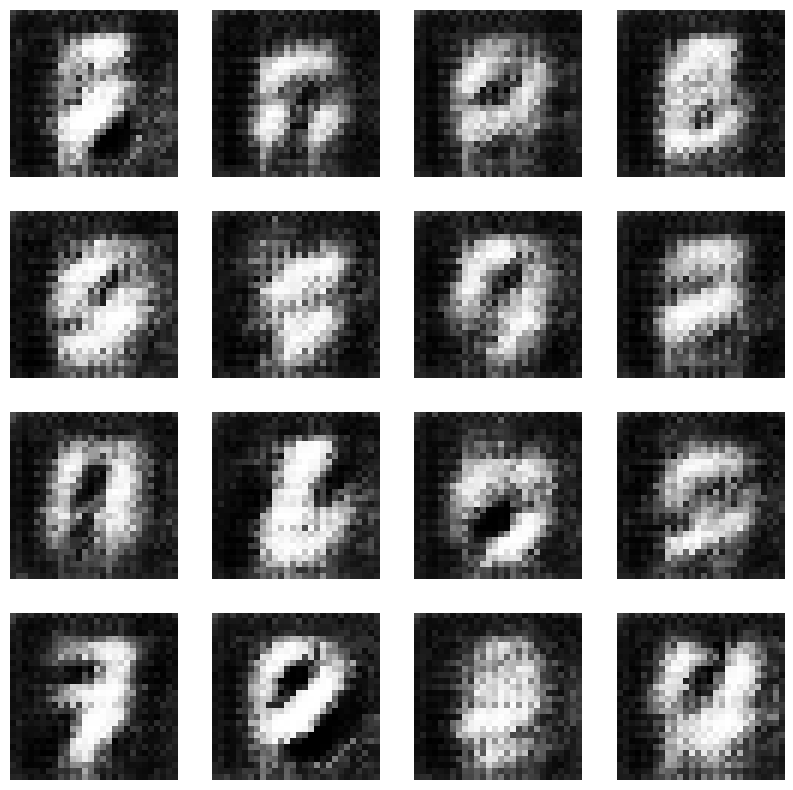

Época:  7


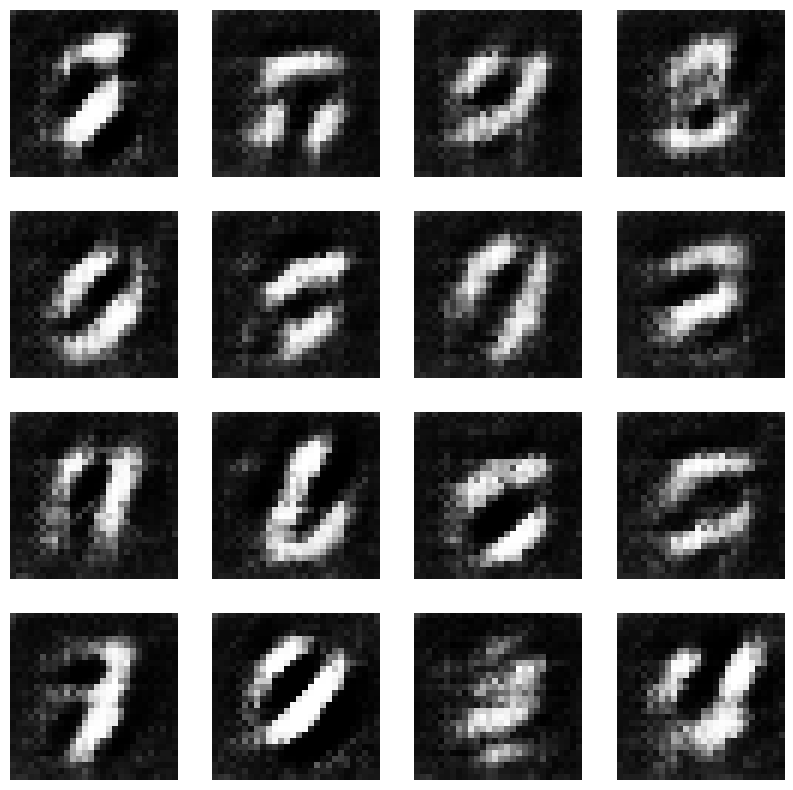

Época:  8


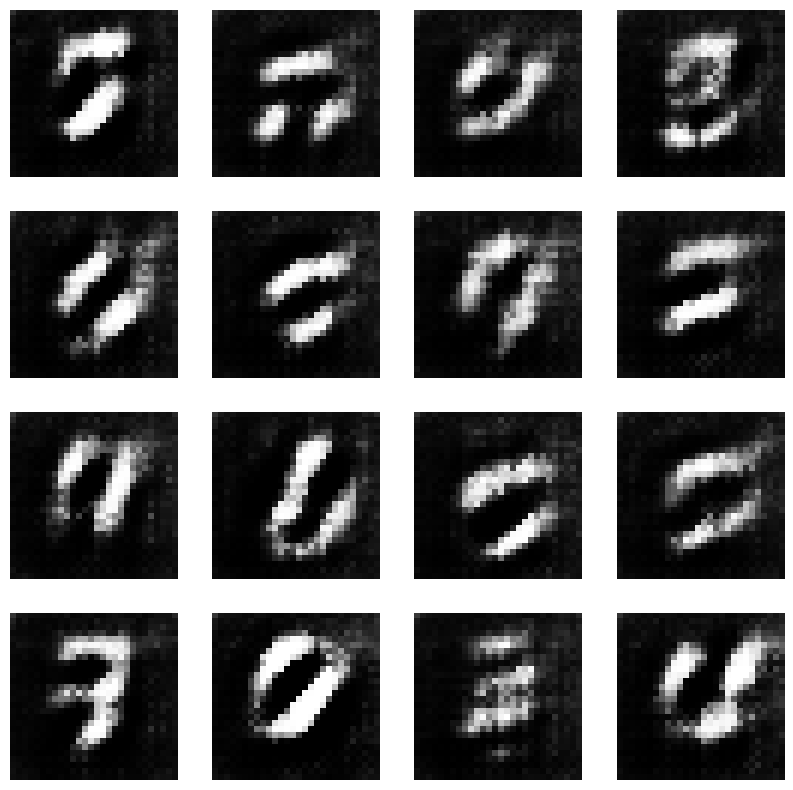

Época:  9


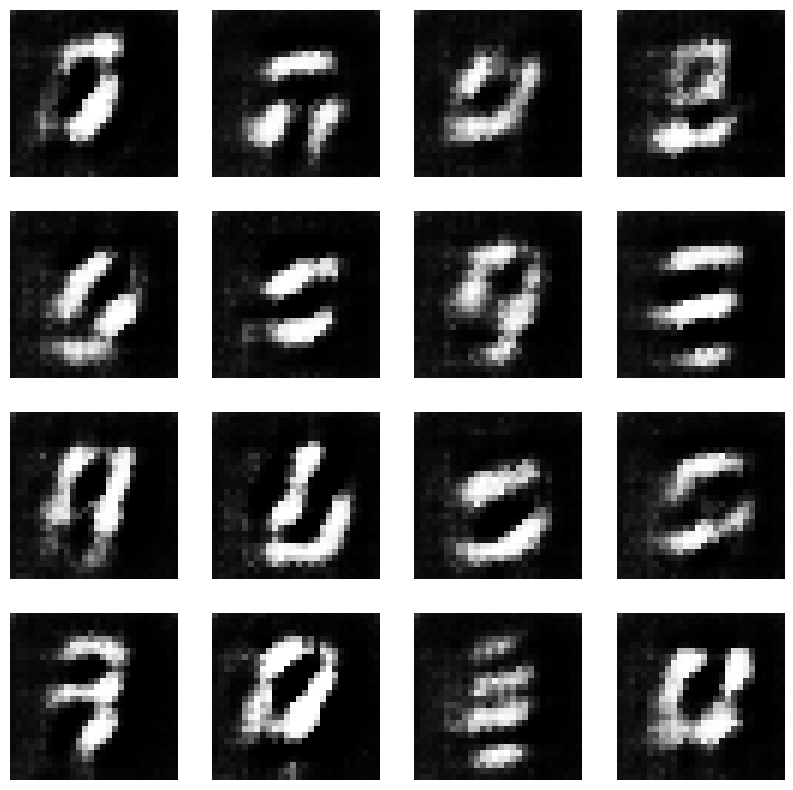

Época:  10


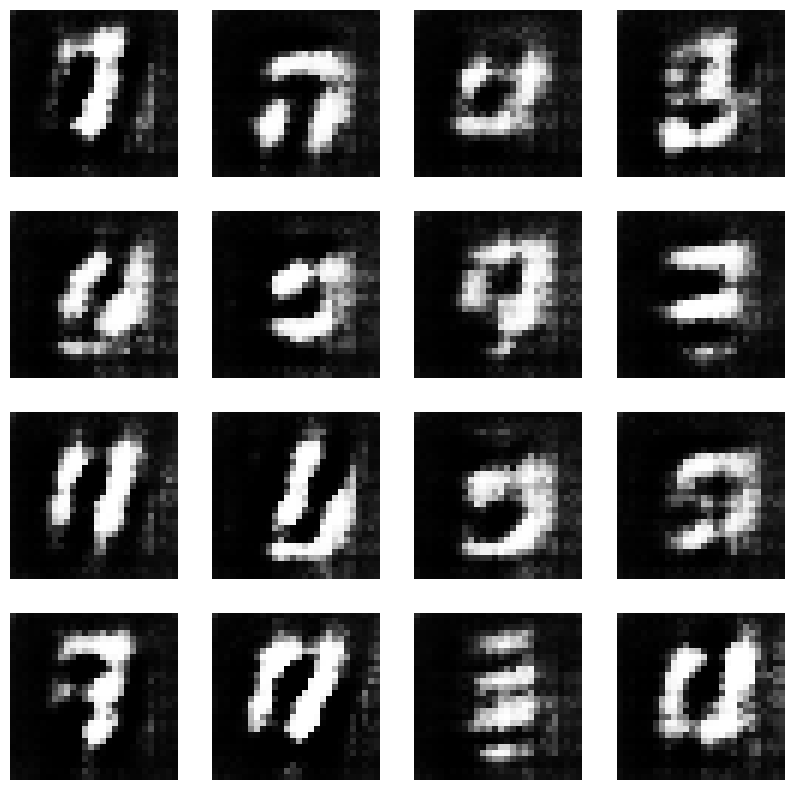

Época:  11


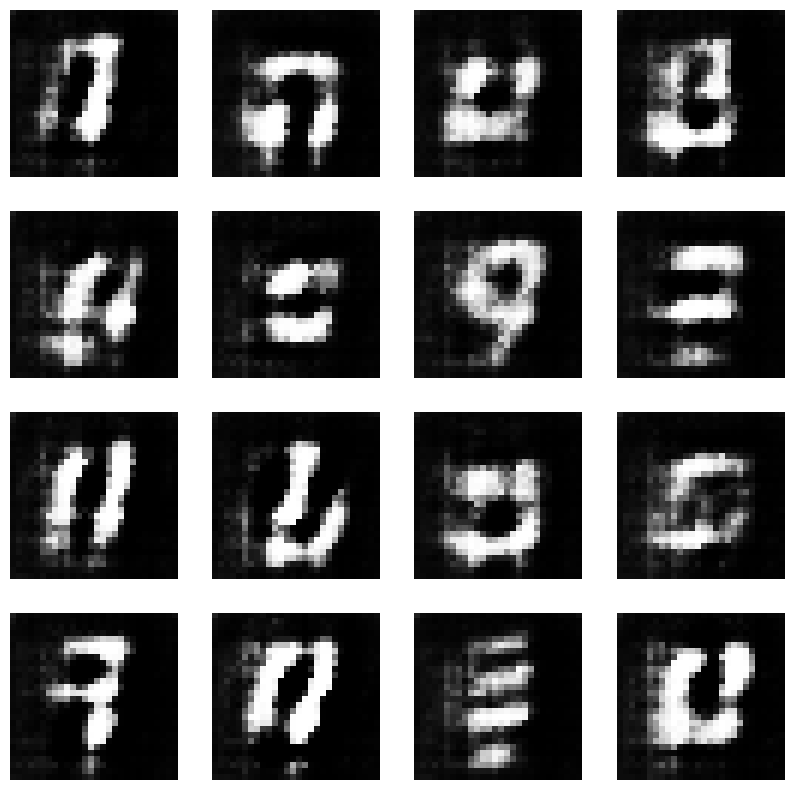

Época:  12


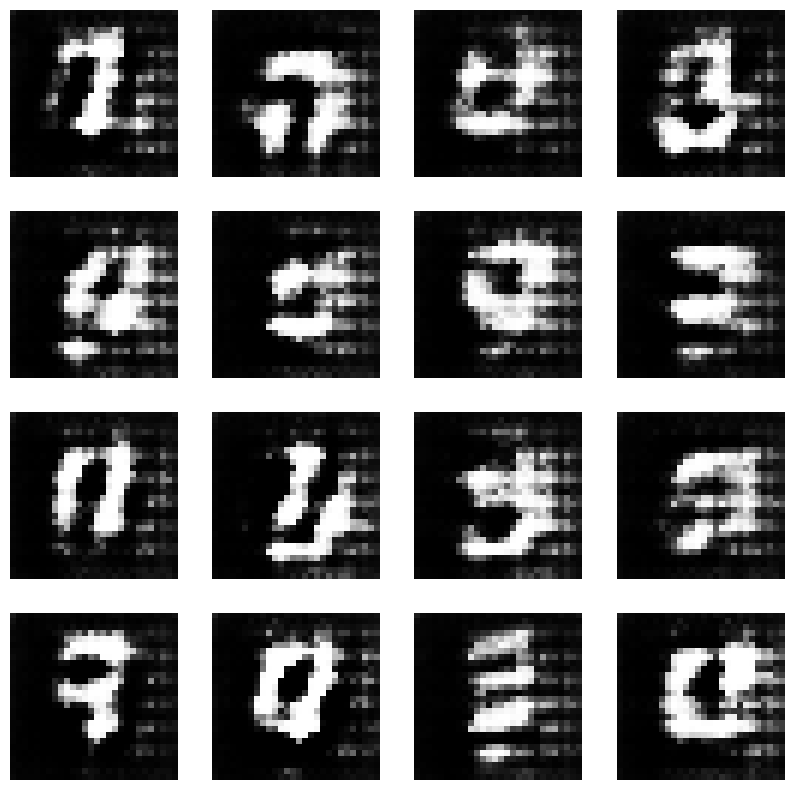

Época:  13


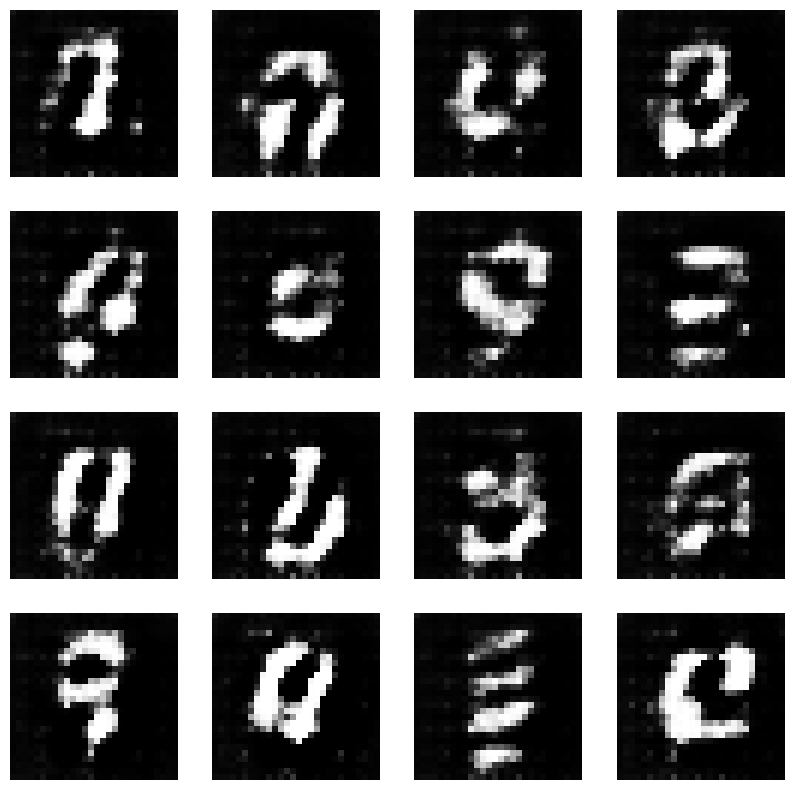

Época:  14


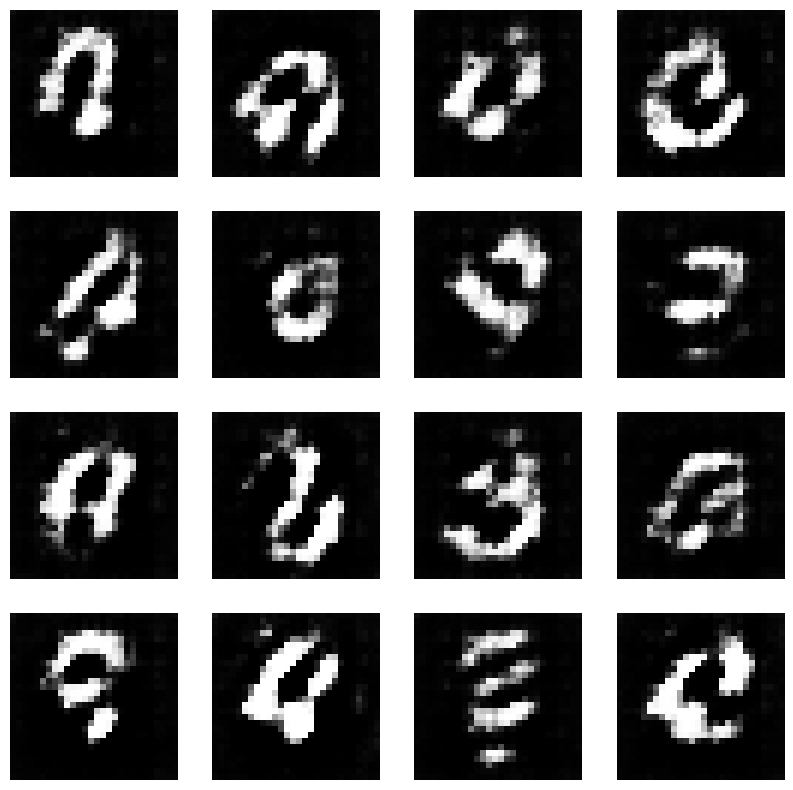

Época:  15


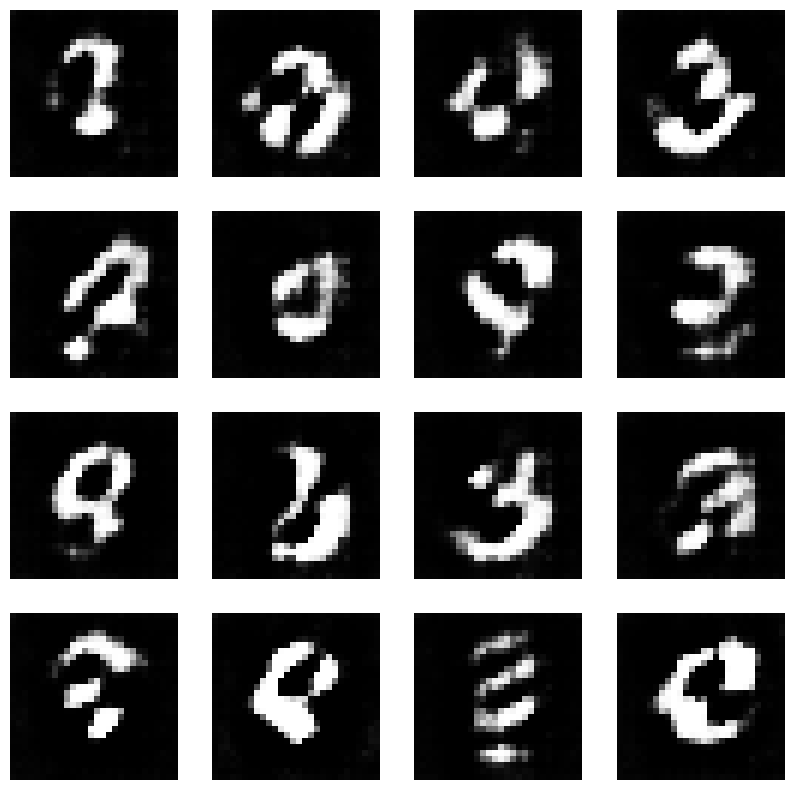

Época:  16


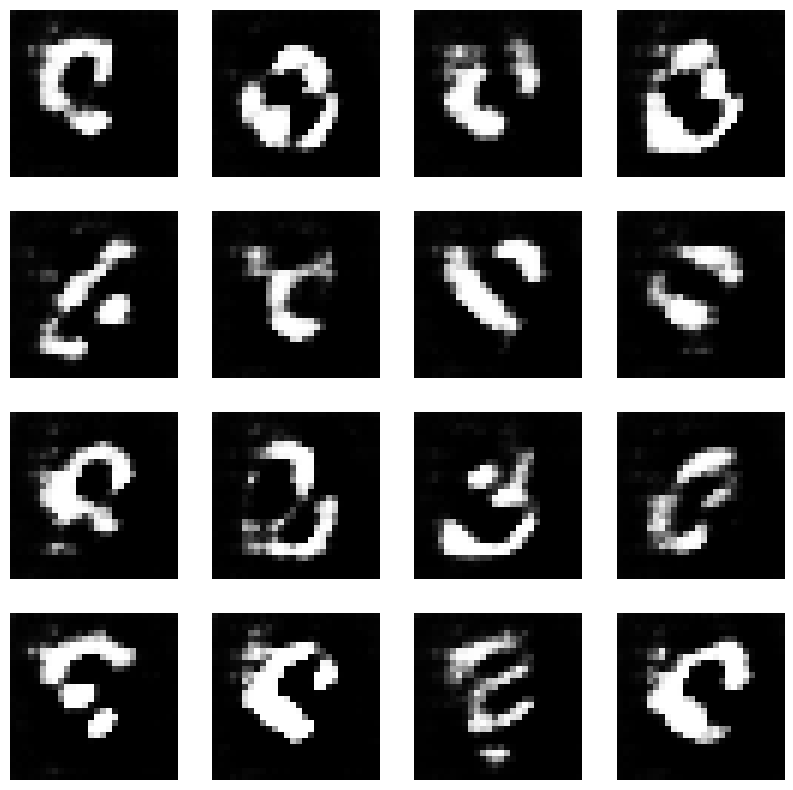

Época:  17


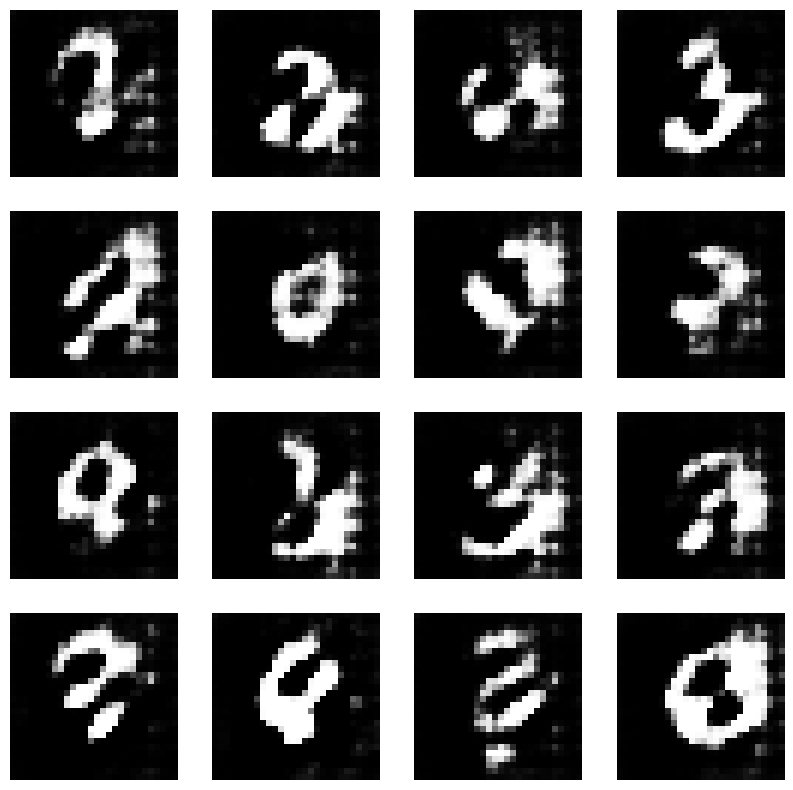

Época:  18


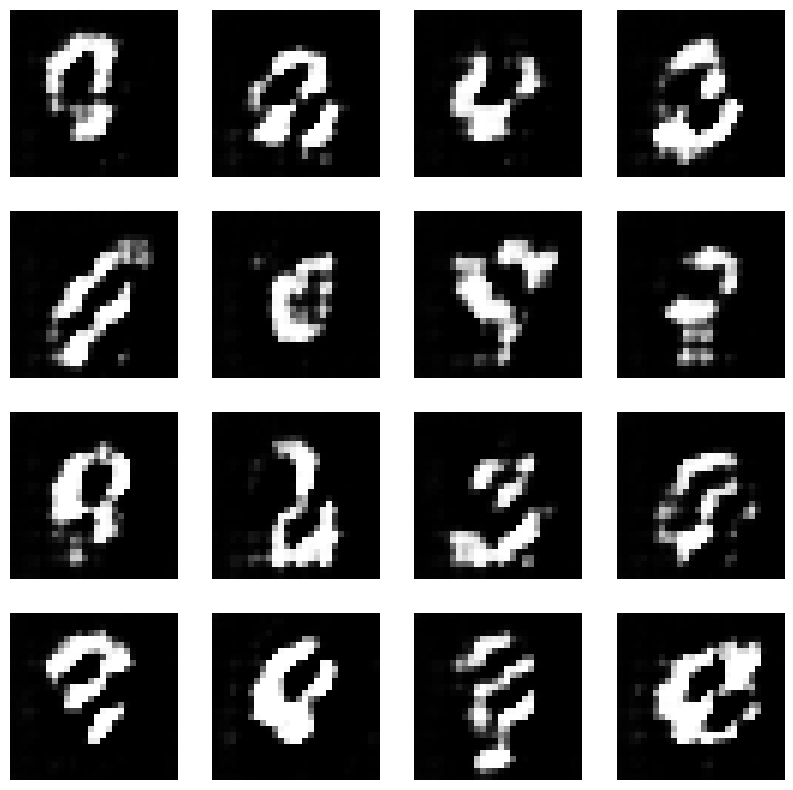

Época:  19


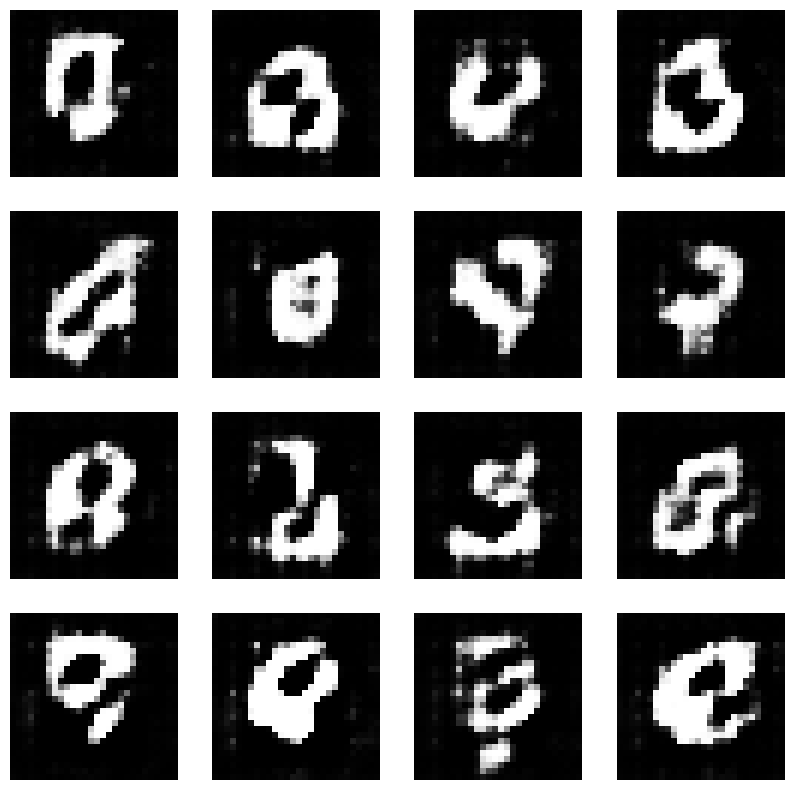

Época:  20


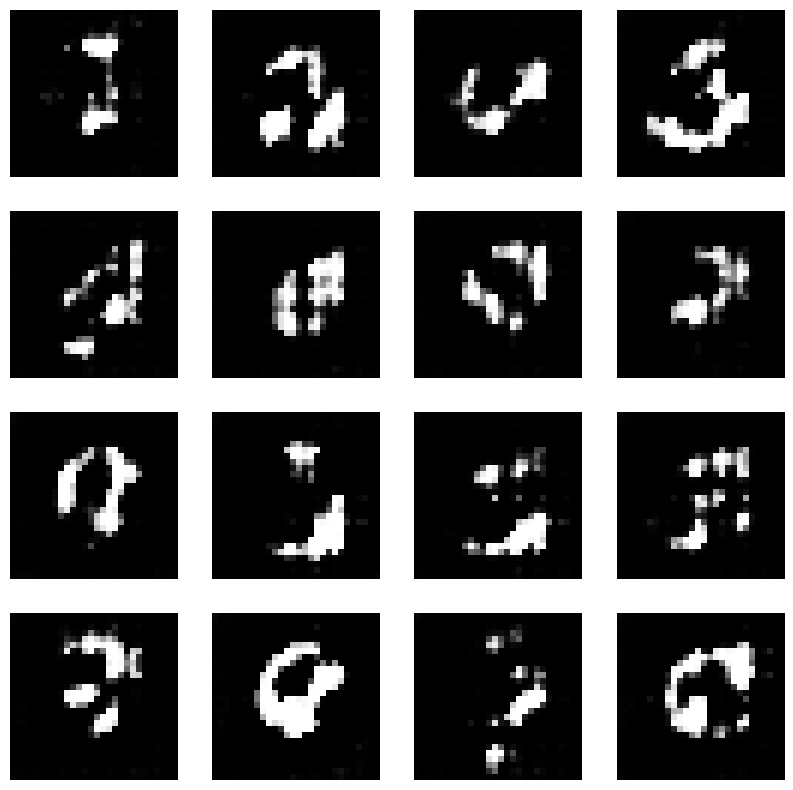

Época:  21


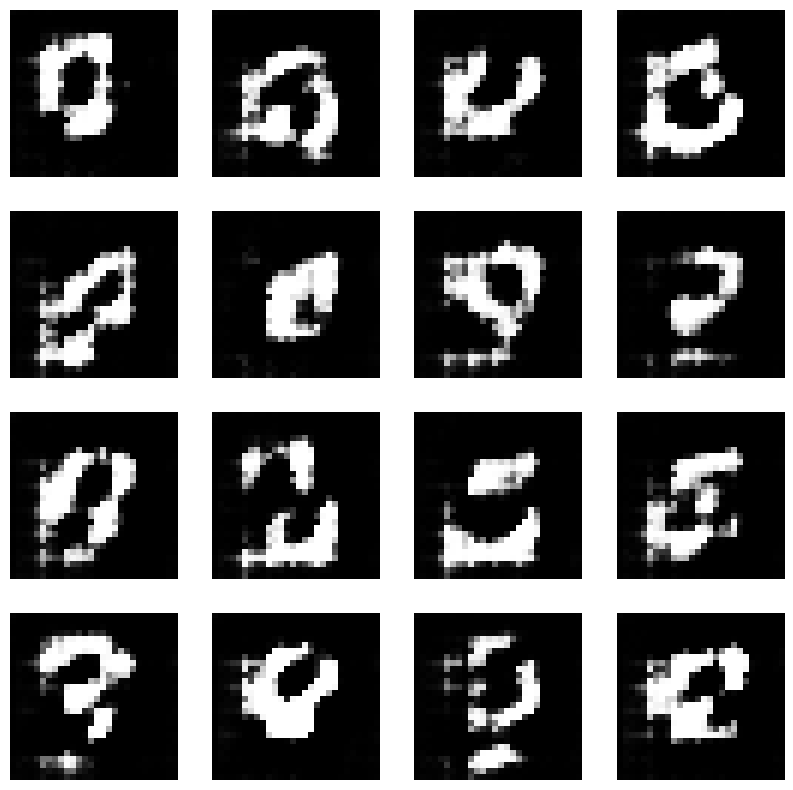

Época:  22


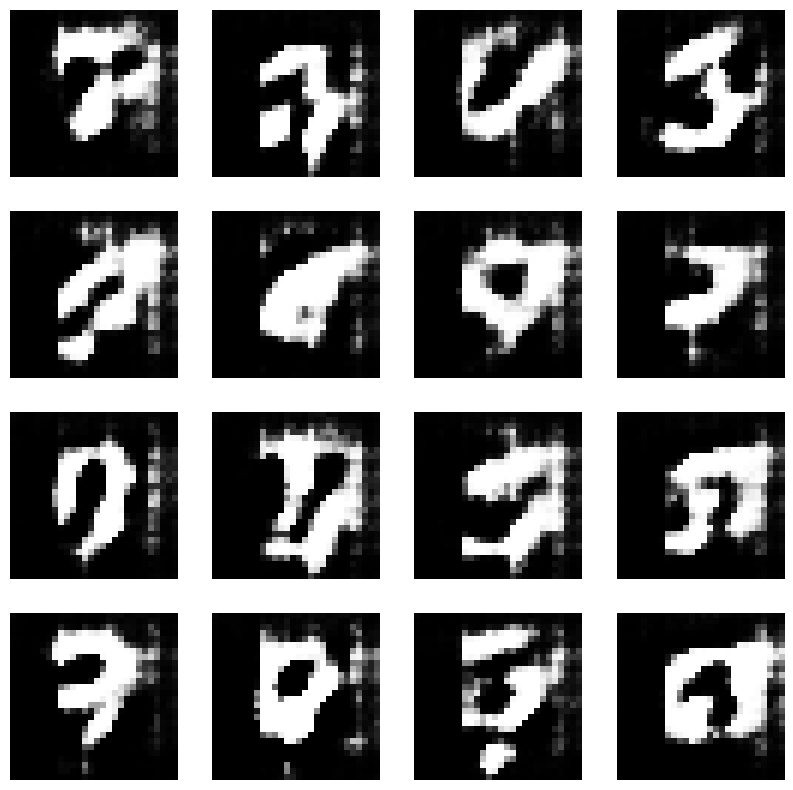

Época:  23


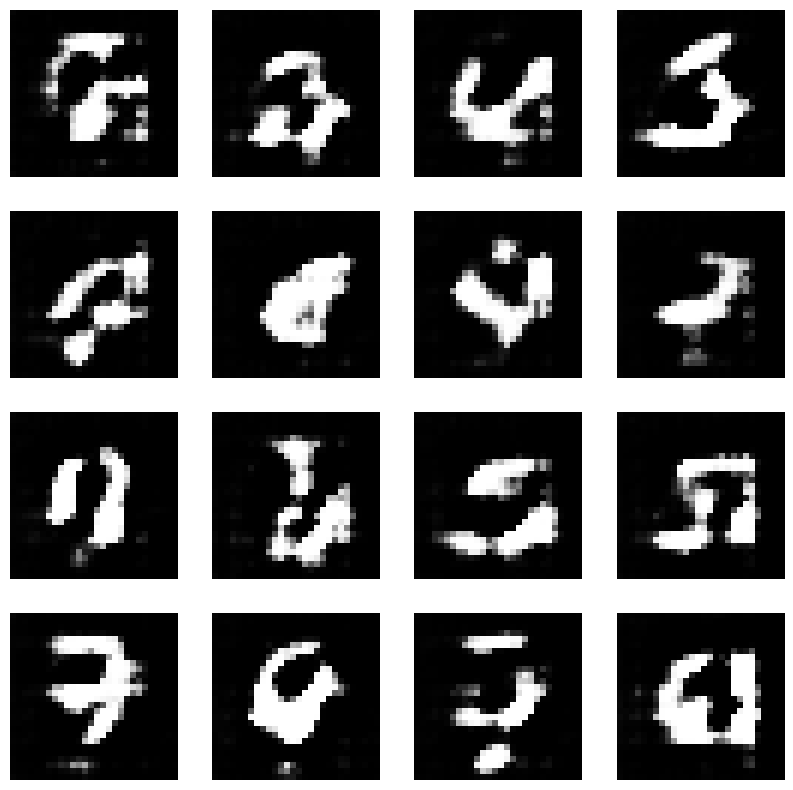

Época:  24


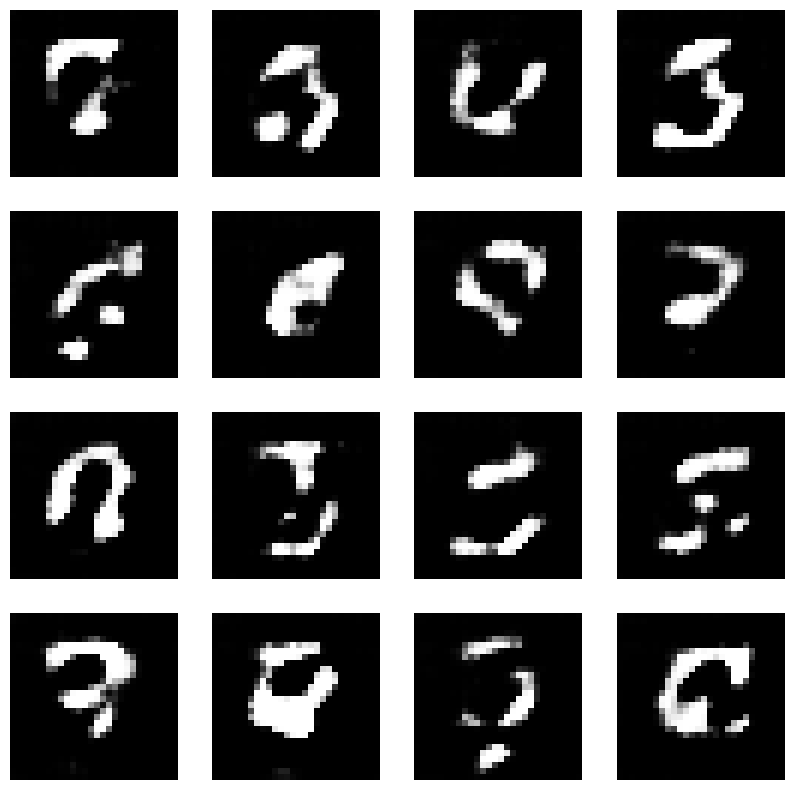

Época:  25


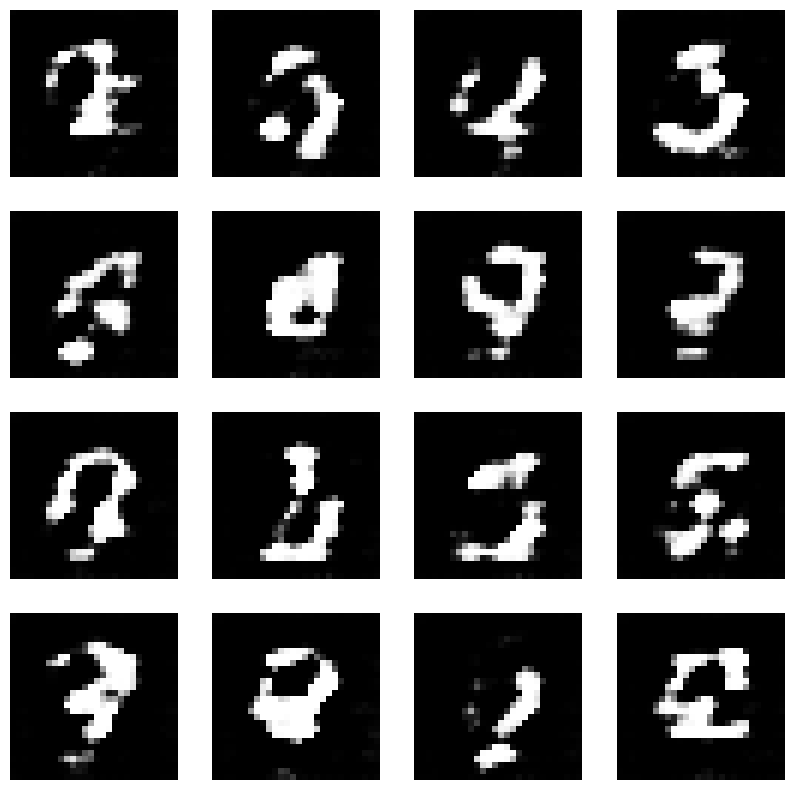

Época:  26


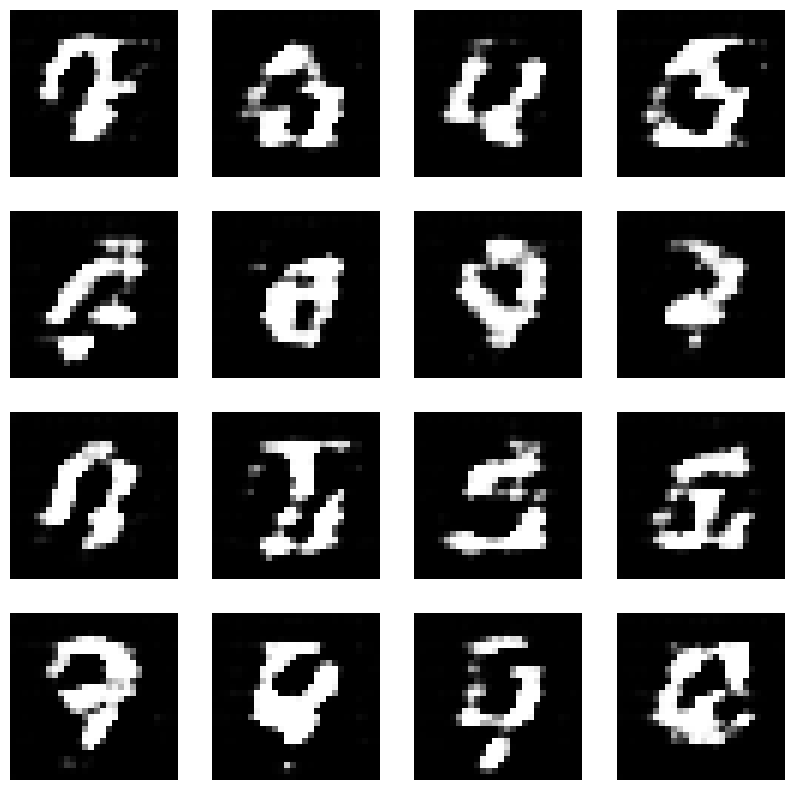

Época:  27


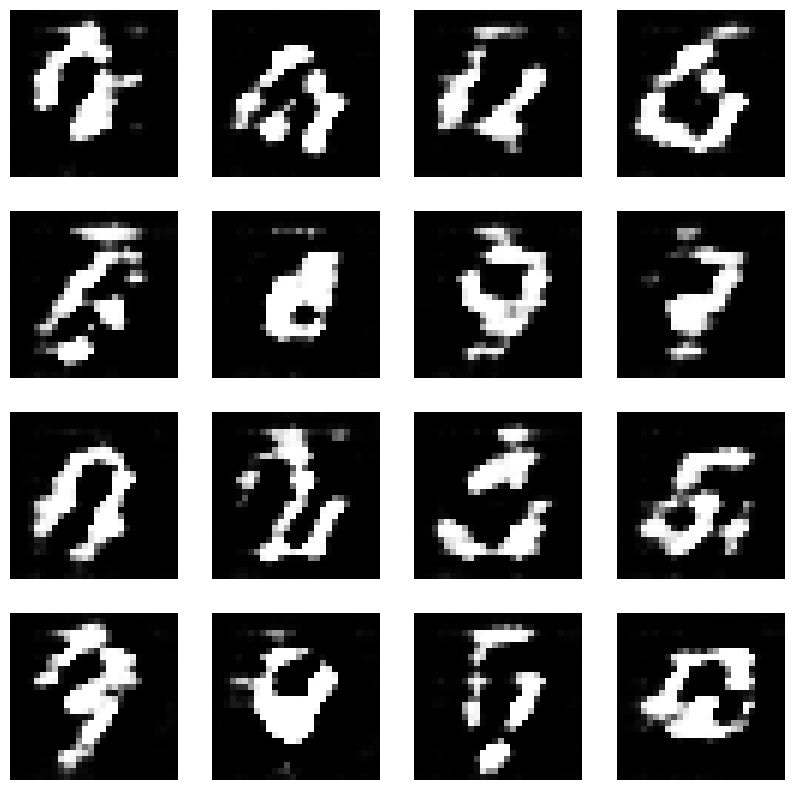

Época:  28


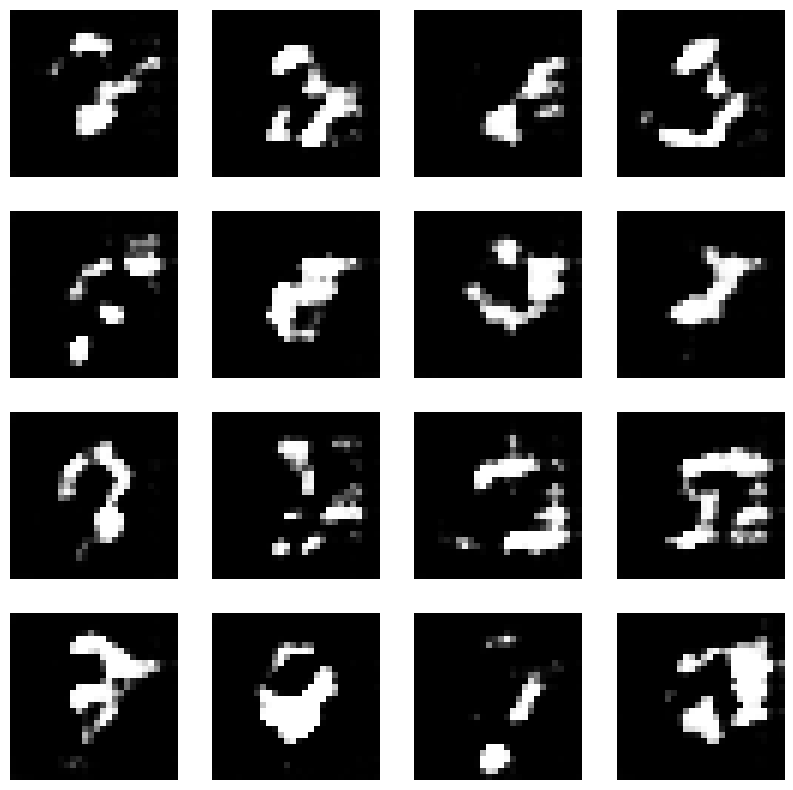

Época:  29


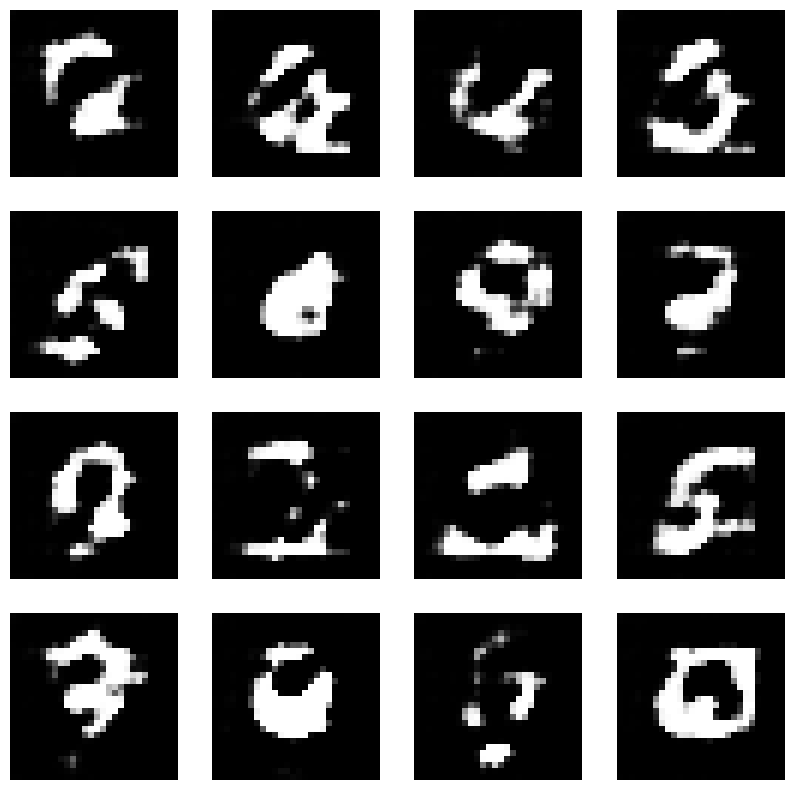

Época:  30


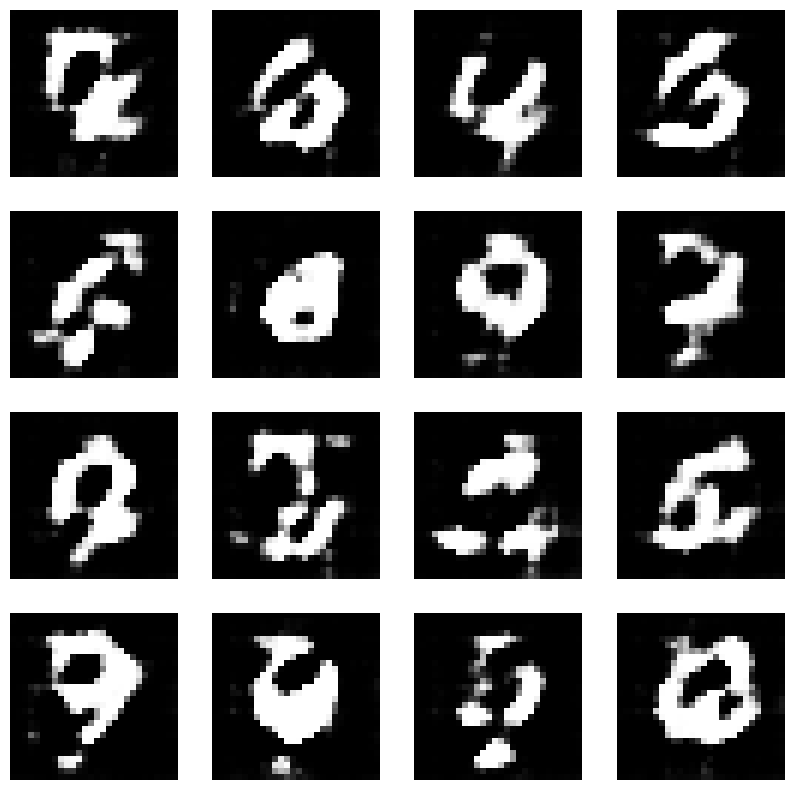

Época:  31


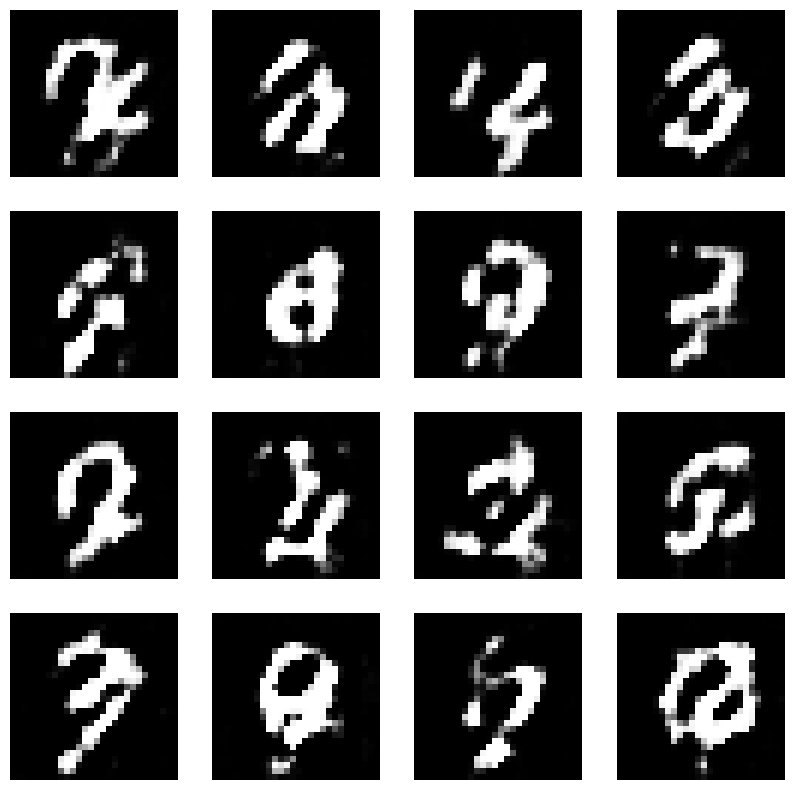

Época:  32


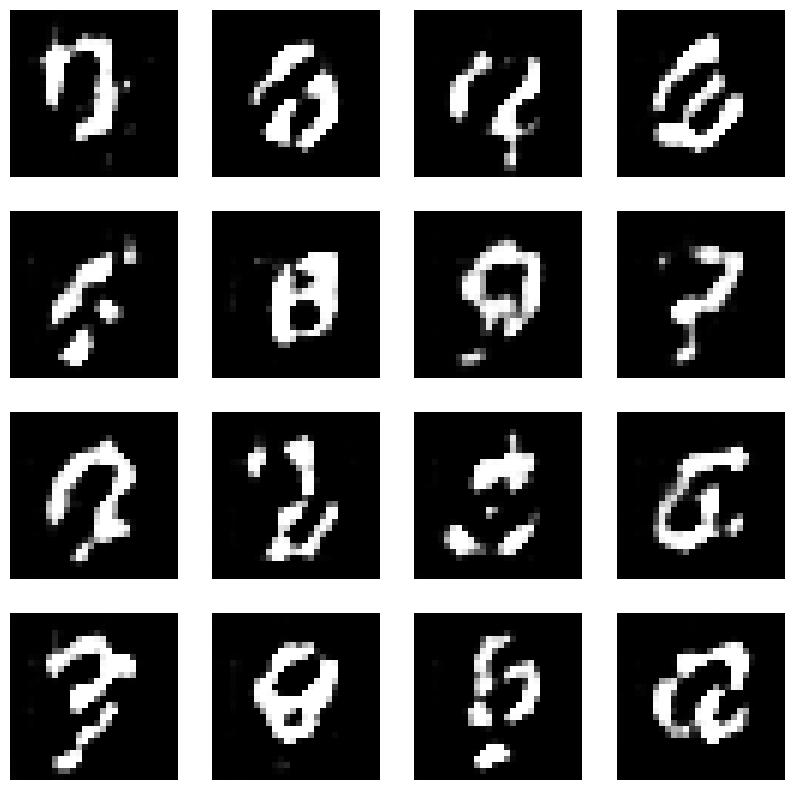

Época:  33


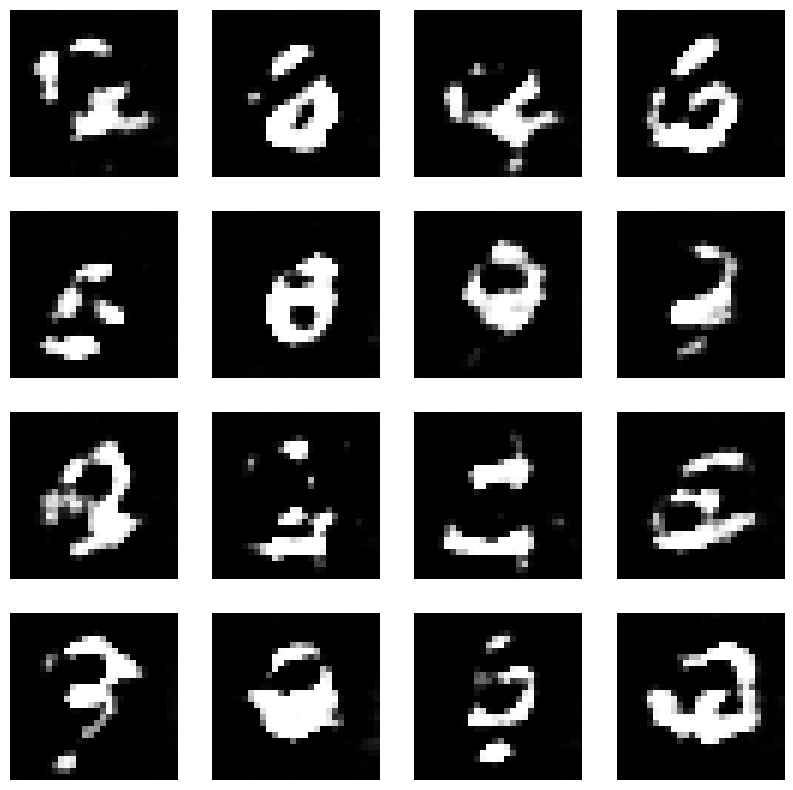

Época:  34


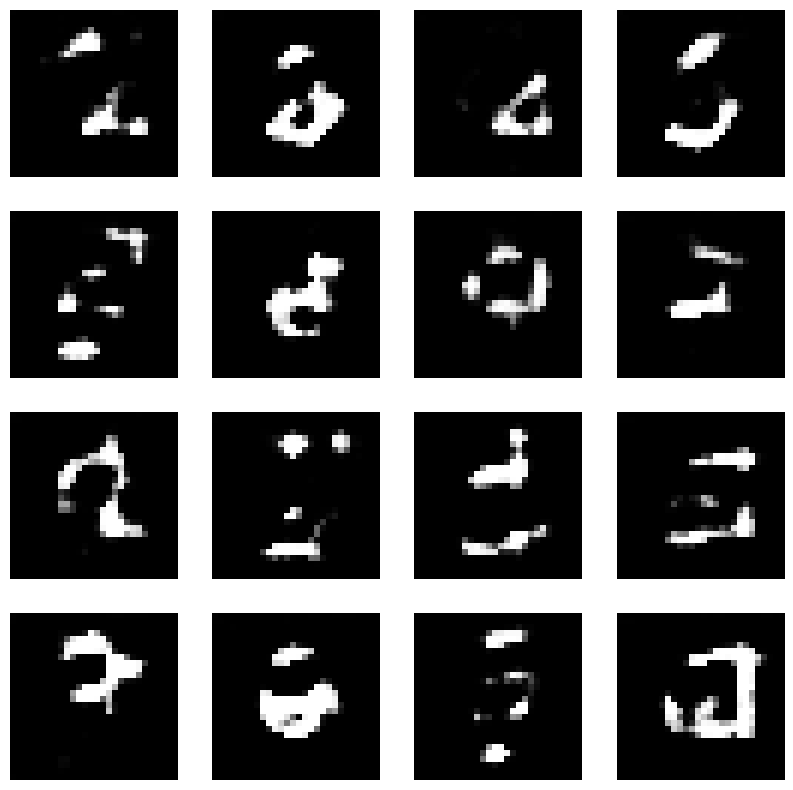

Época:  35


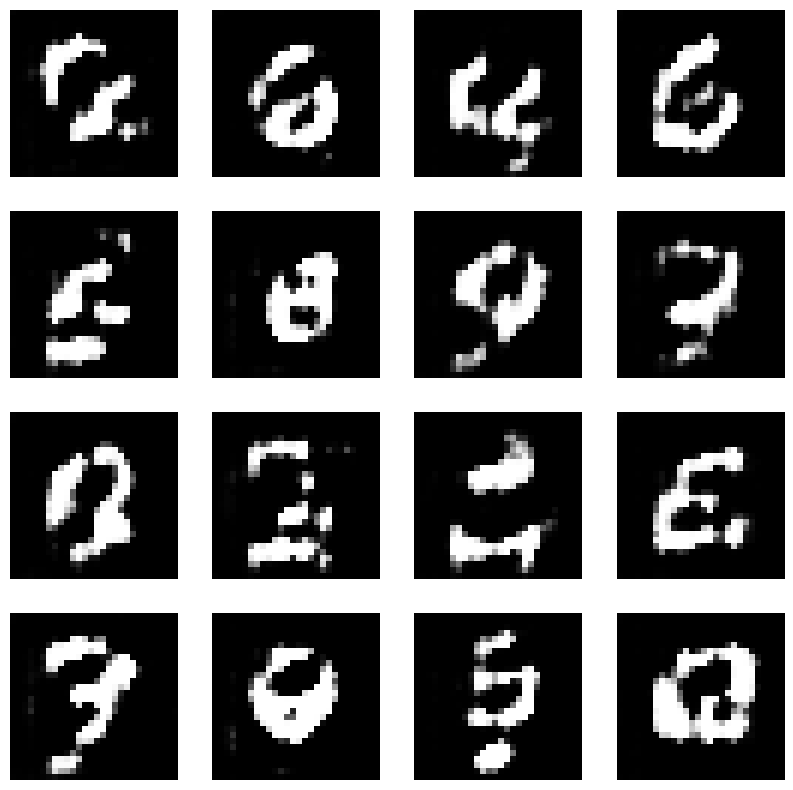

Época:  36


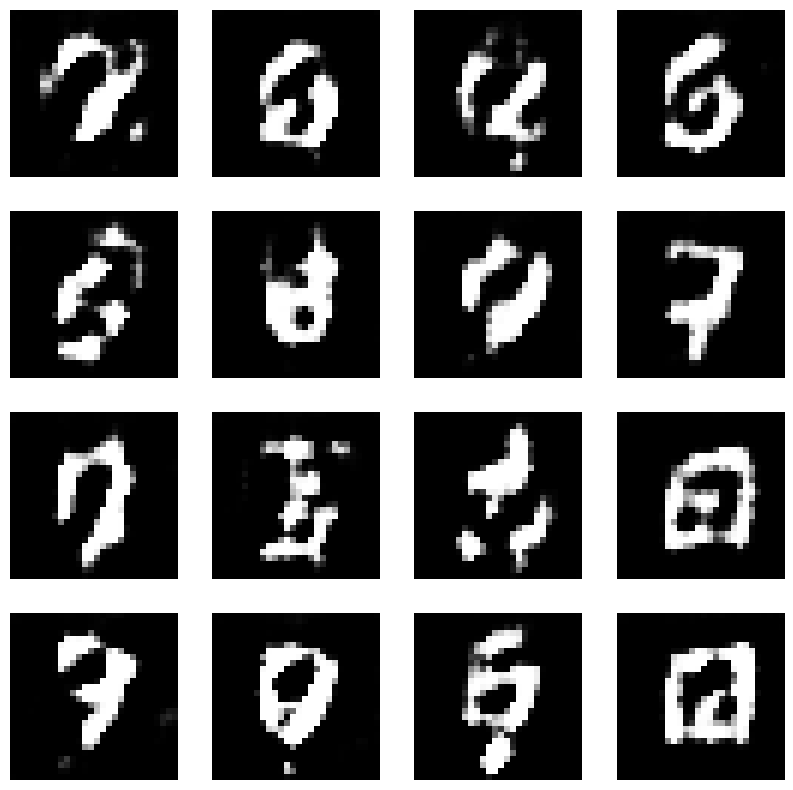

Época:  37


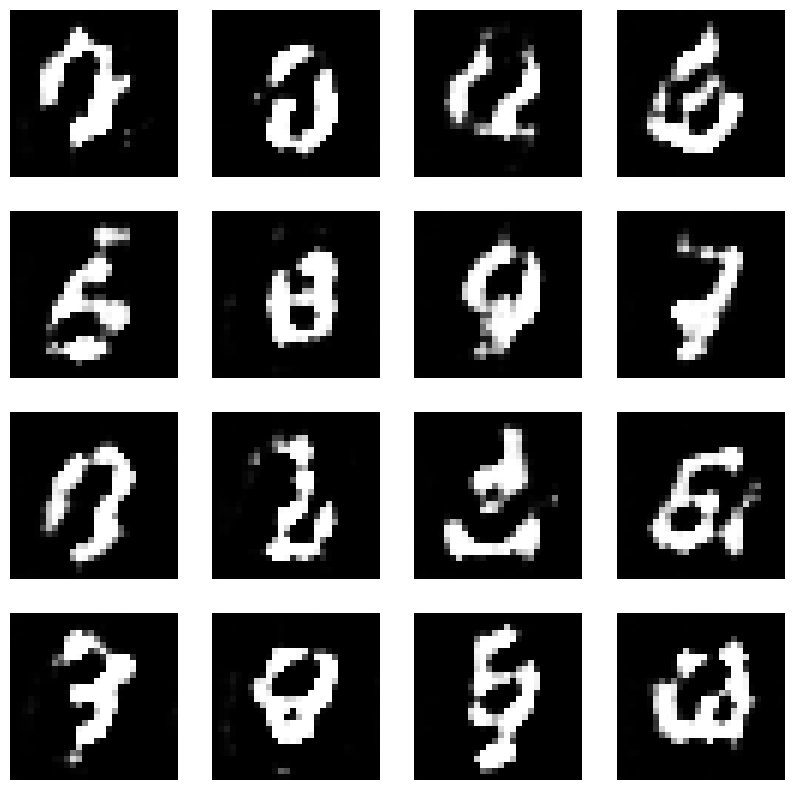

Época:  38


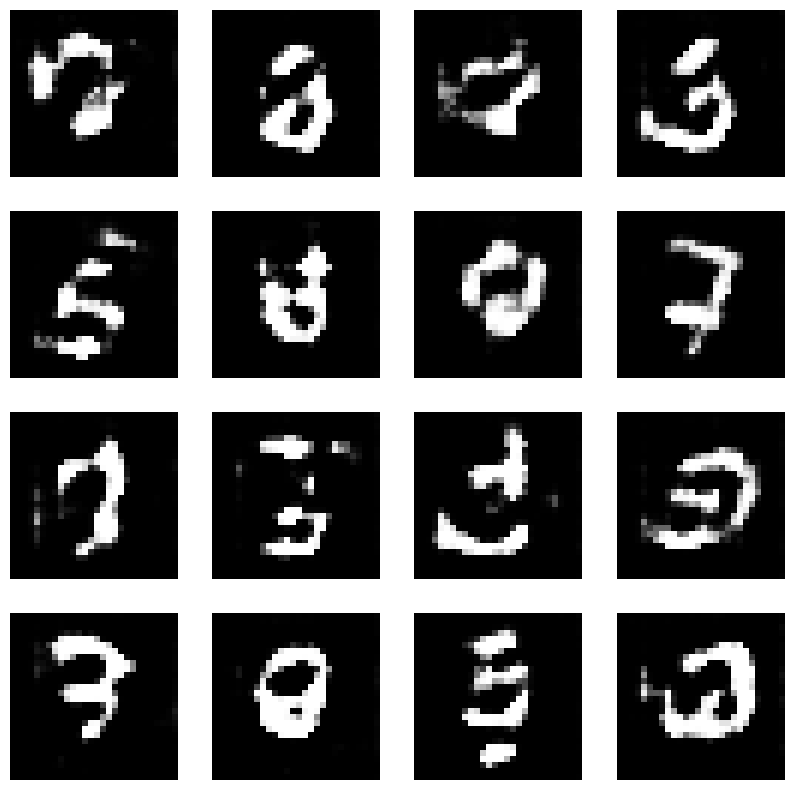

Época:  39


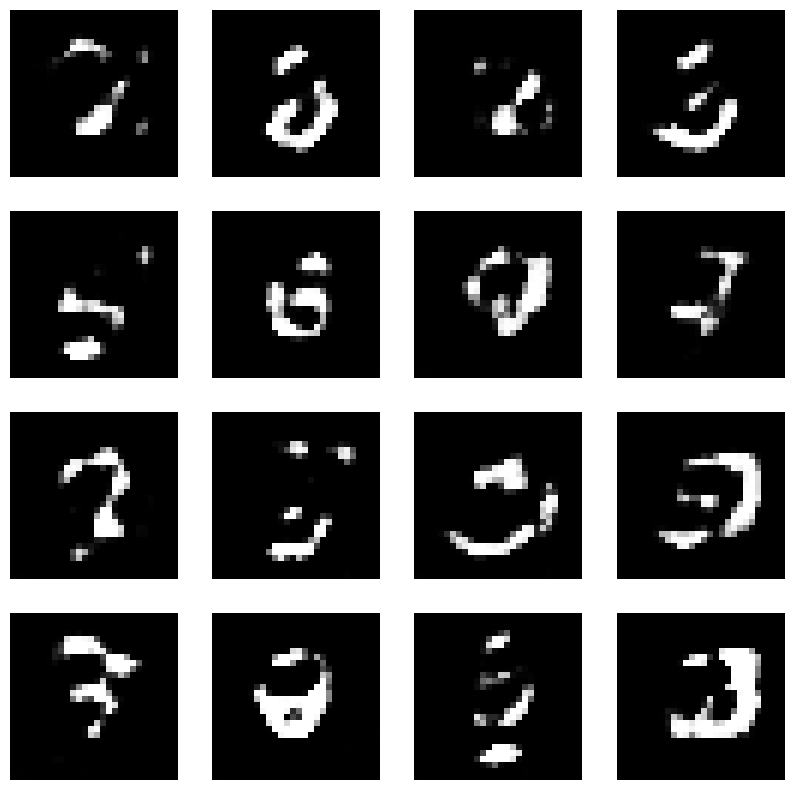

Época:  40


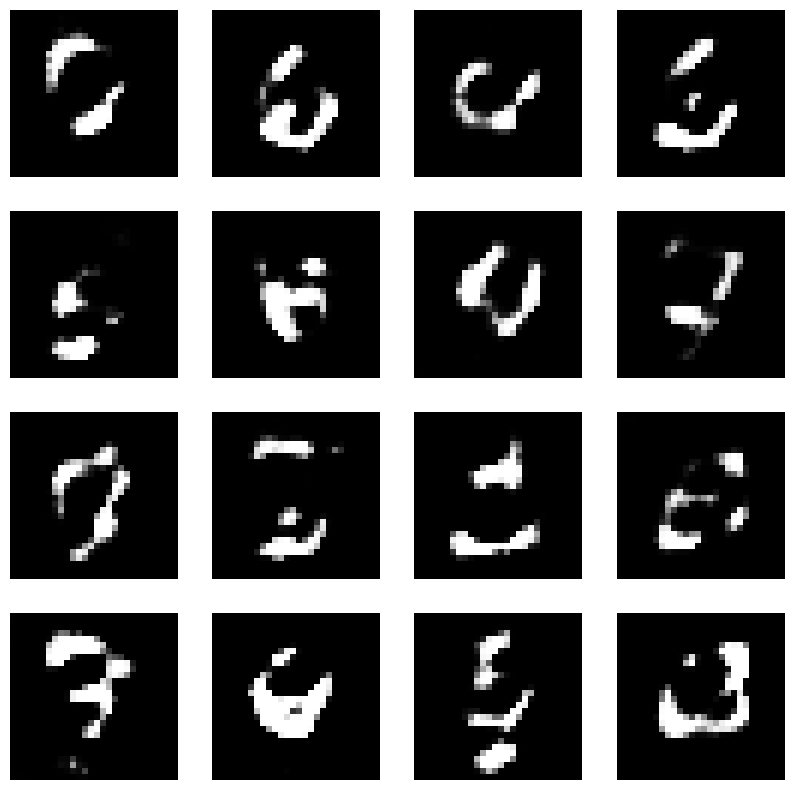

Época:  41


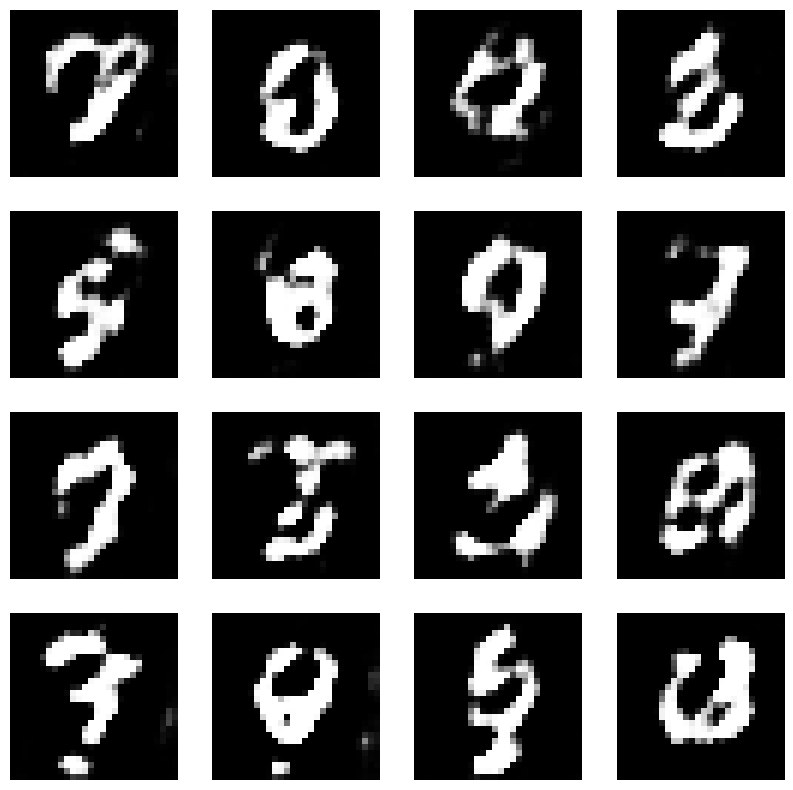

Época:  42


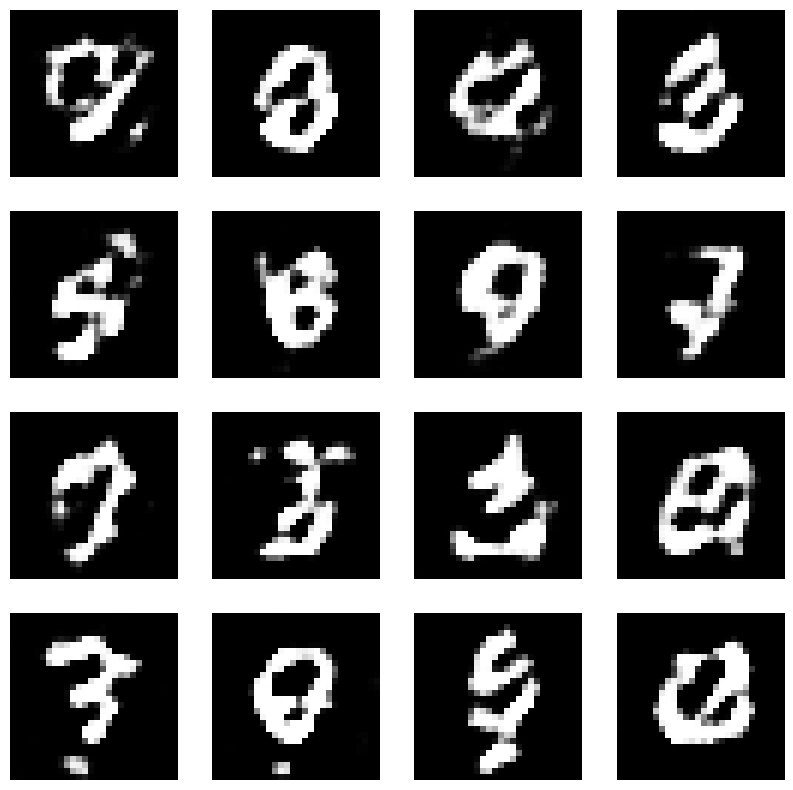

Época:  43


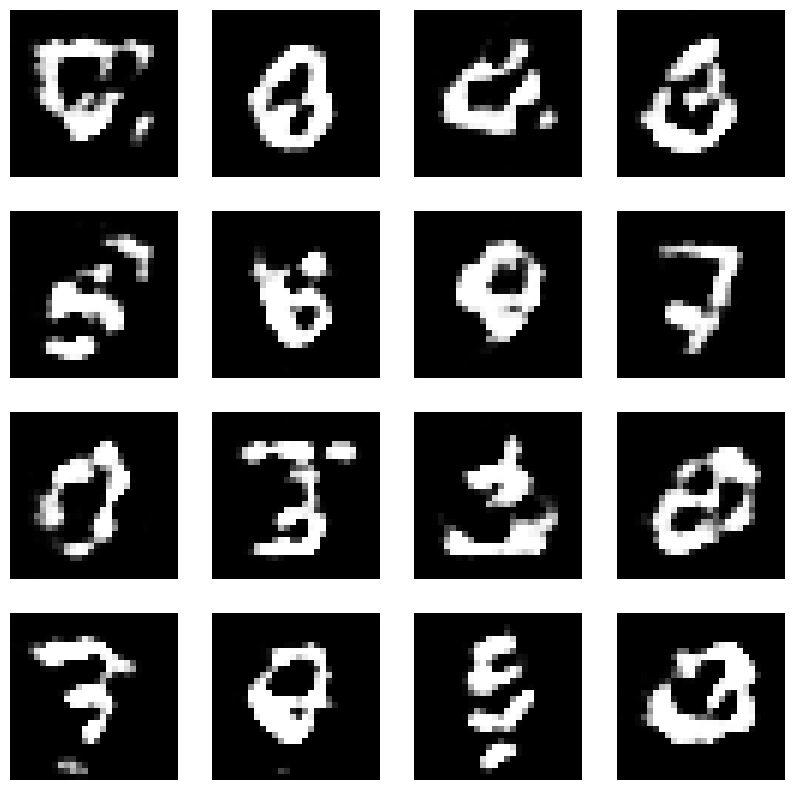

Época:  44


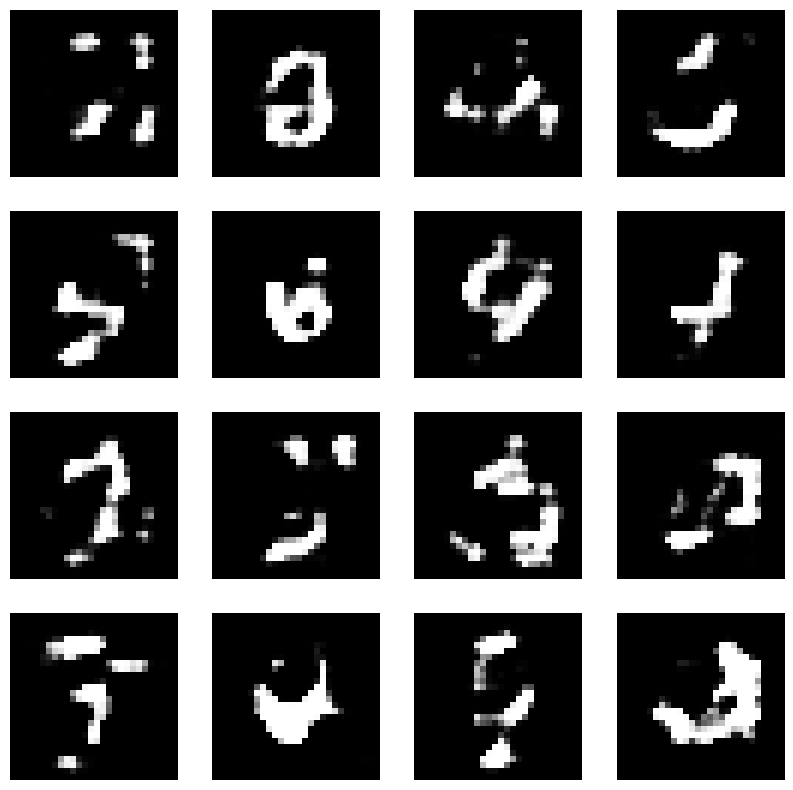

Época:  45


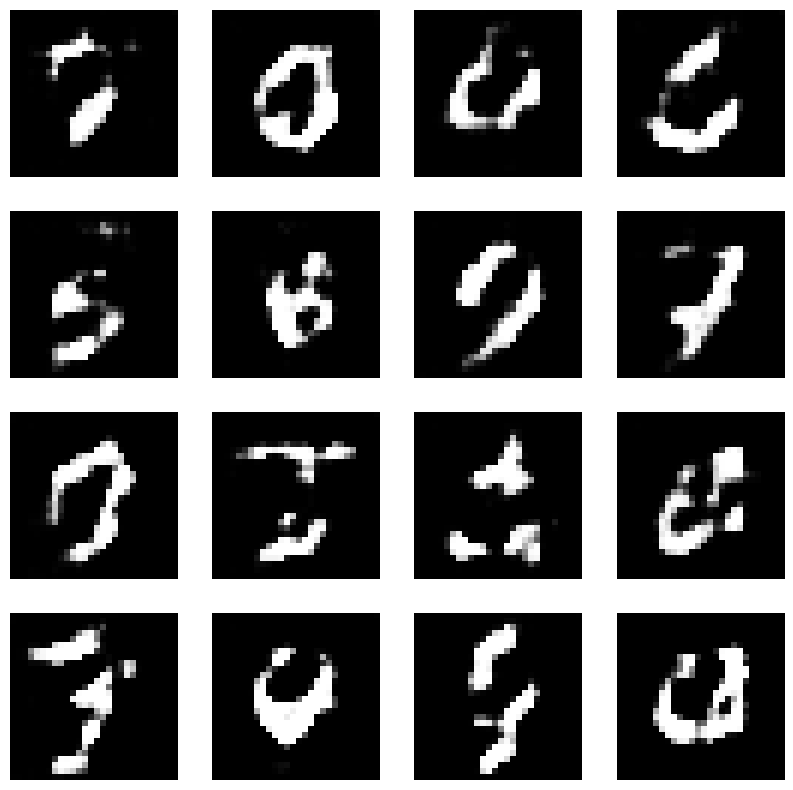

Época:  46


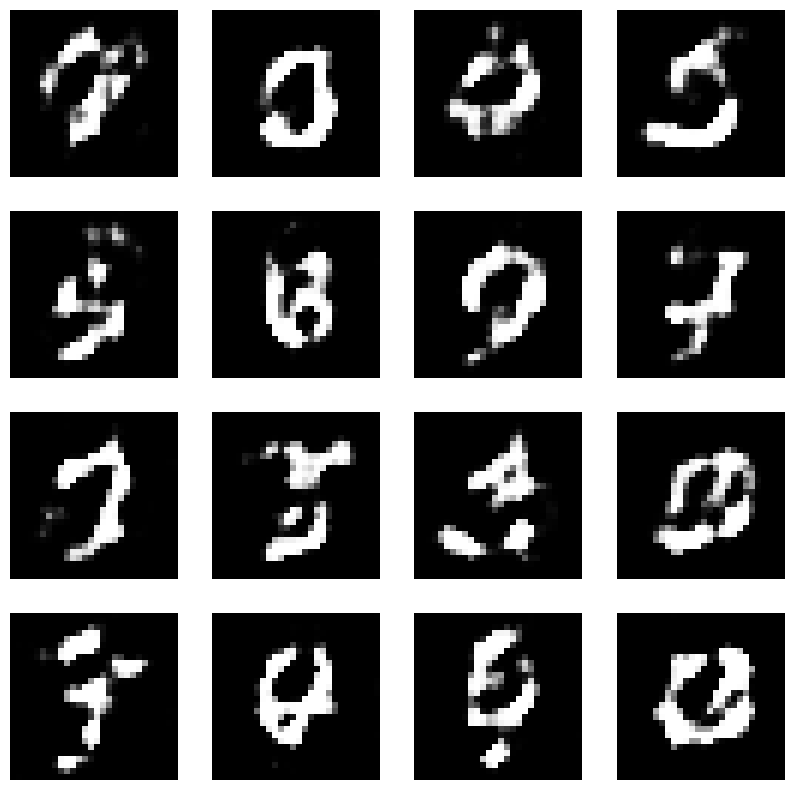

Época:  47


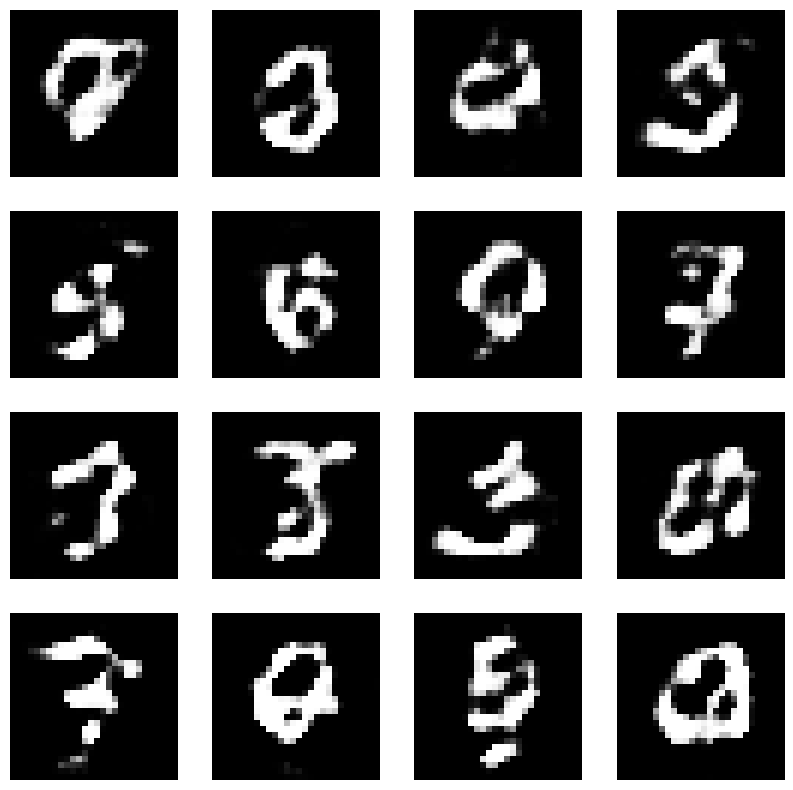

Época:  48


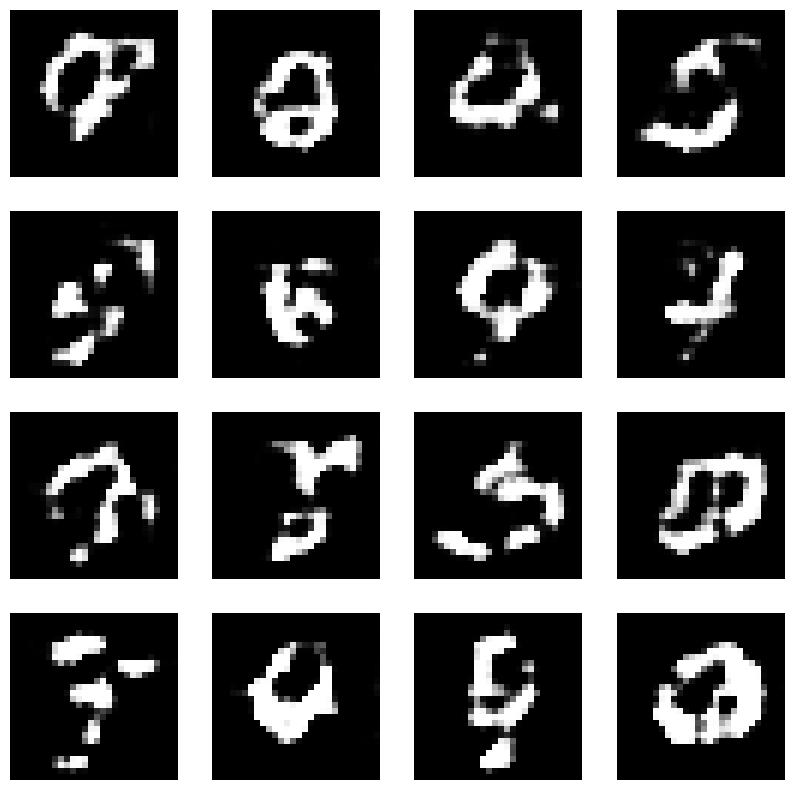

Época:  49


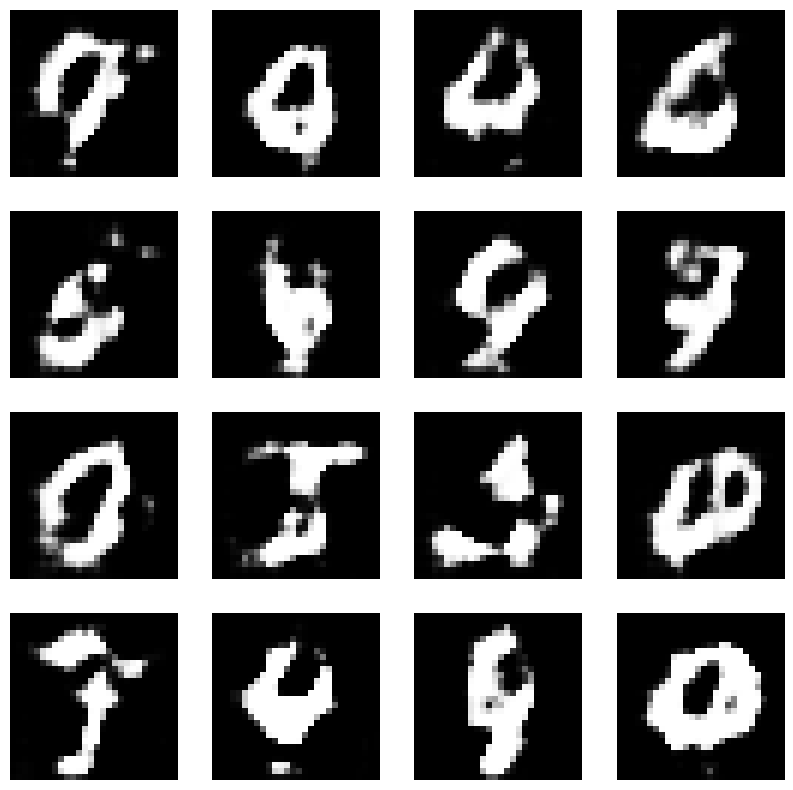

Época:  50


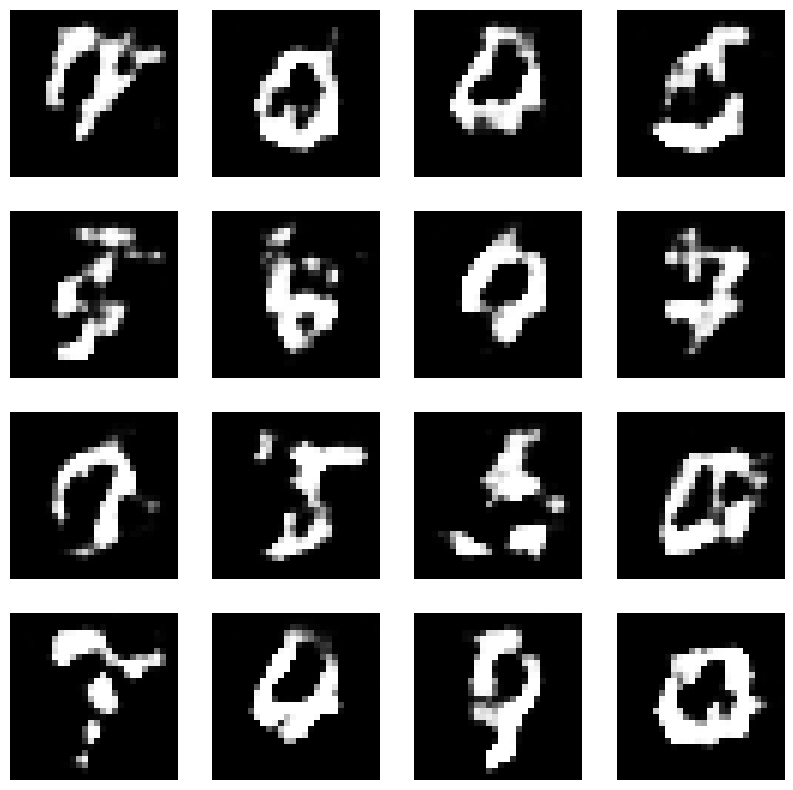

Época:  51


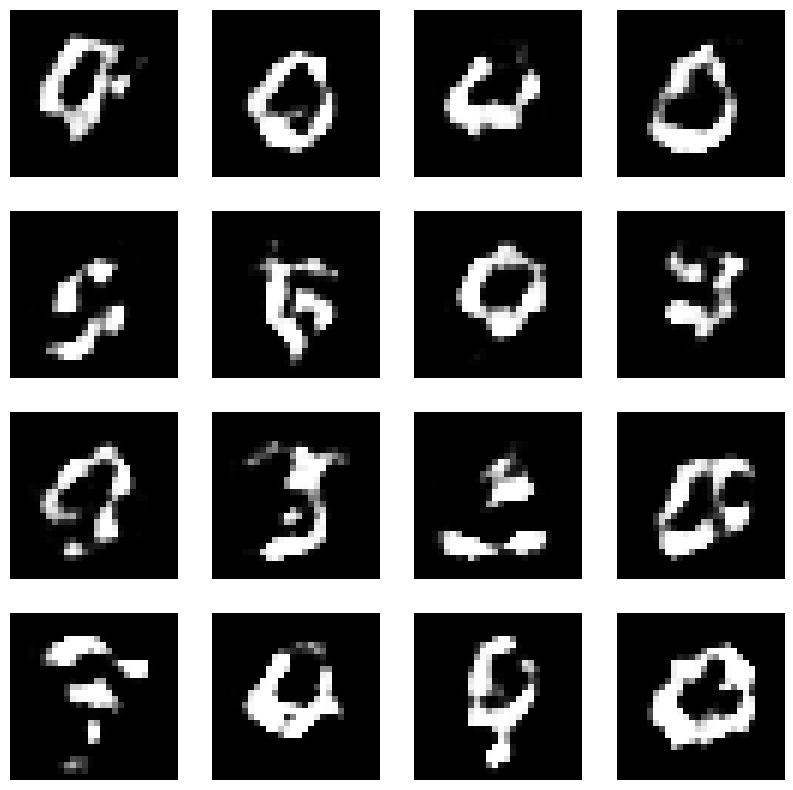

Época:  52


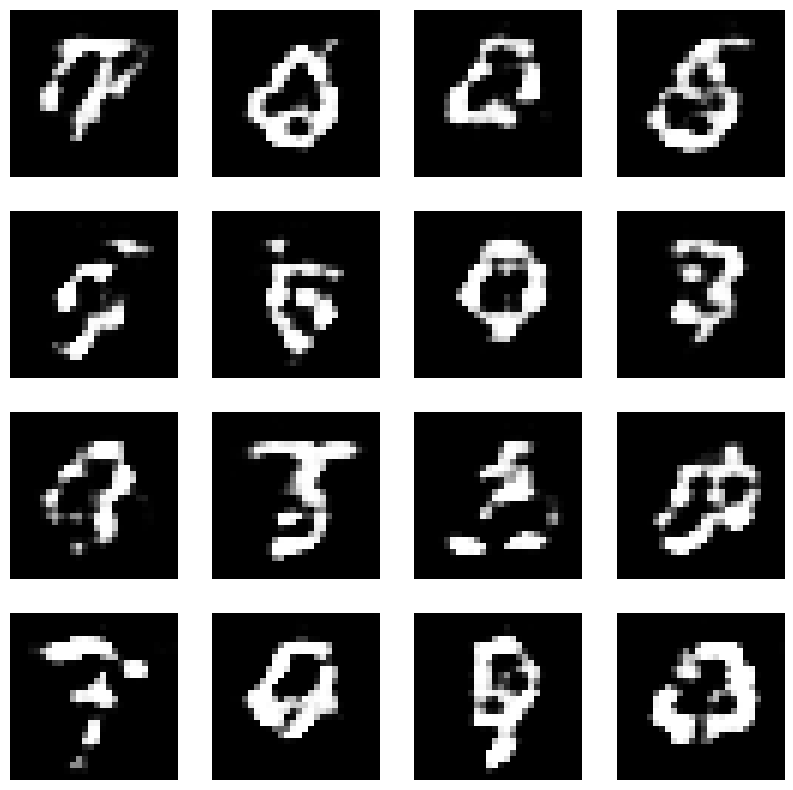

Época:  53


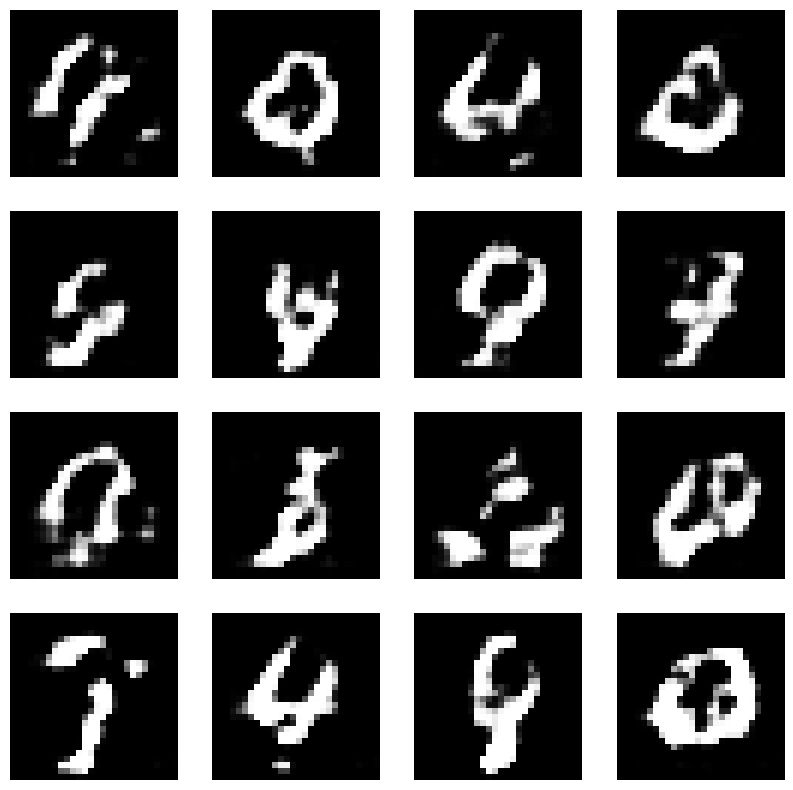

Época:  54


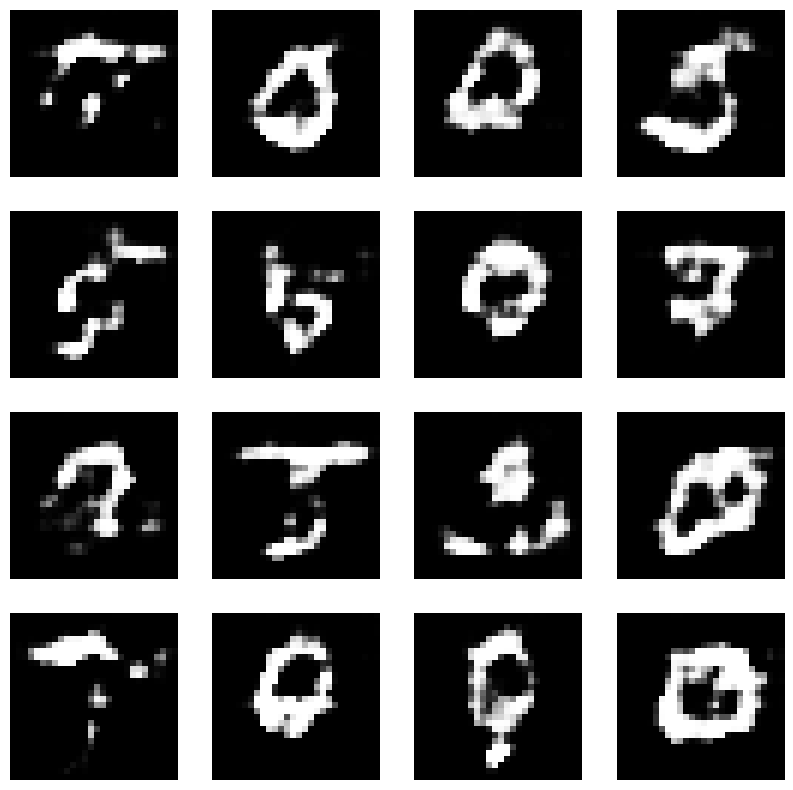

Época:  55


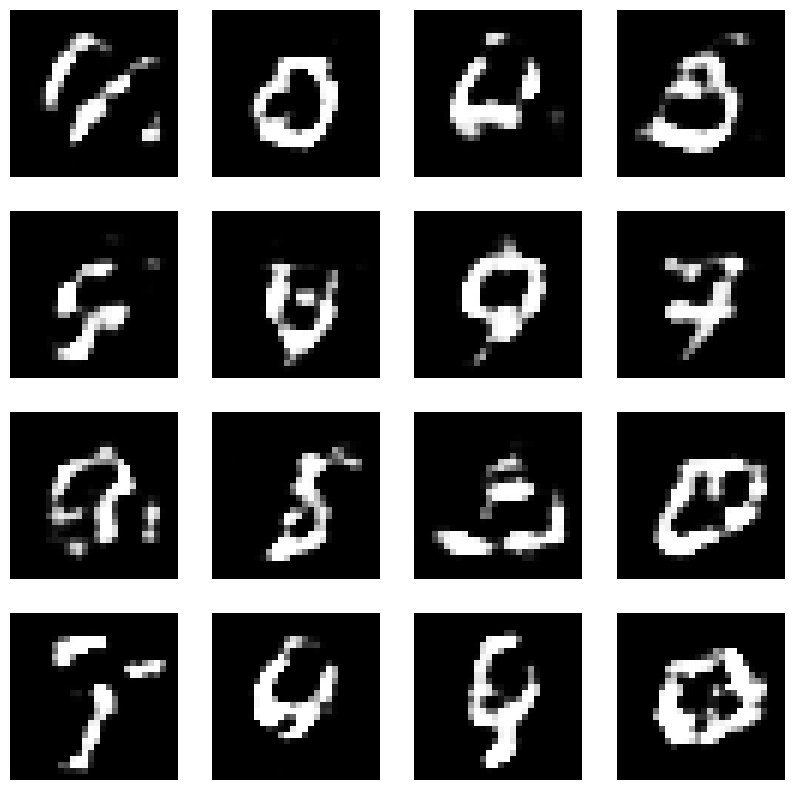

Época:  56


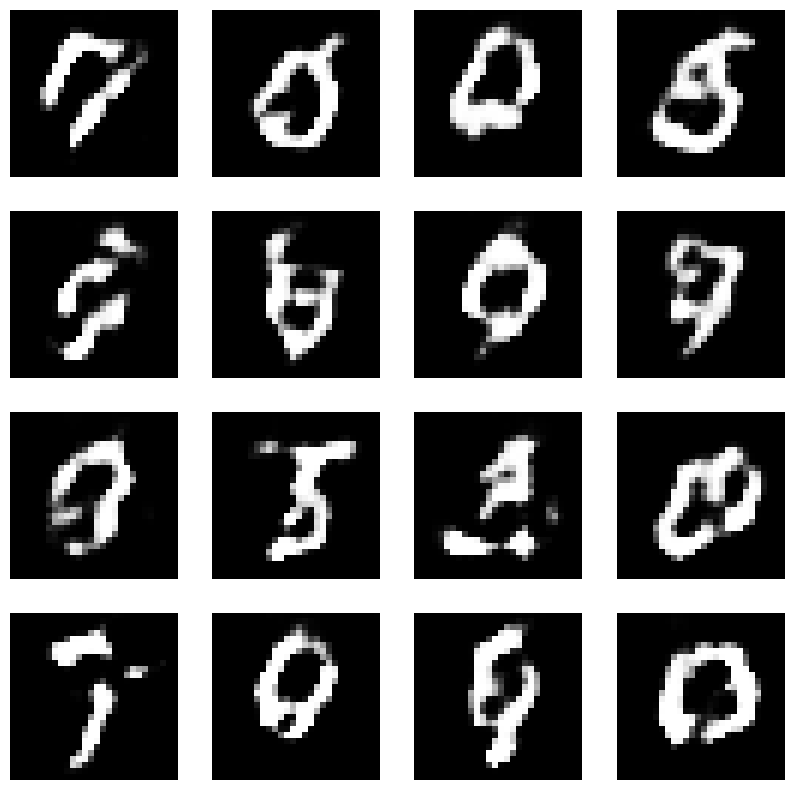

Época:  57


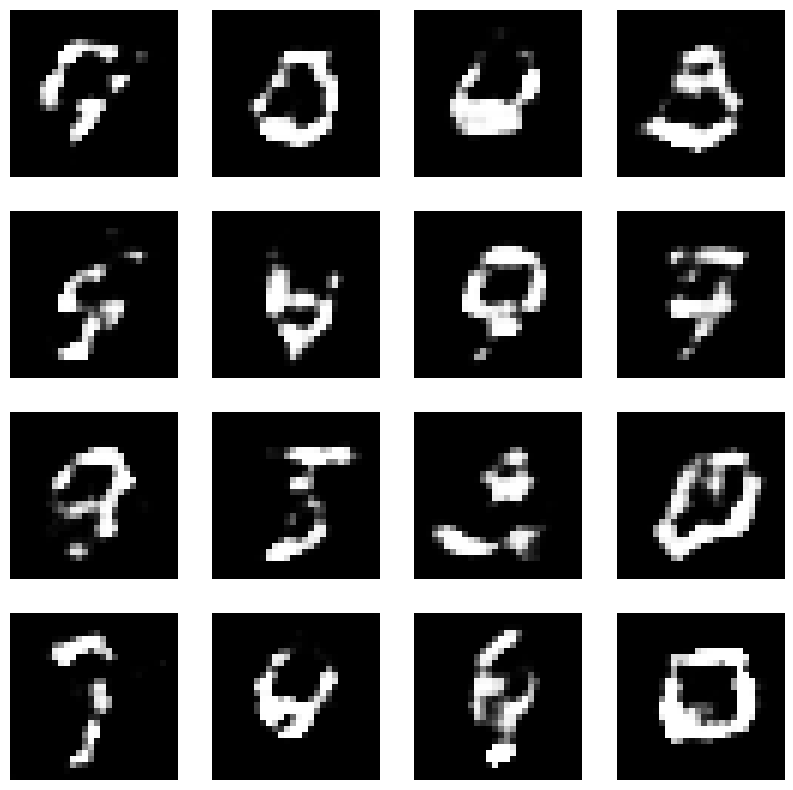

Época:  58


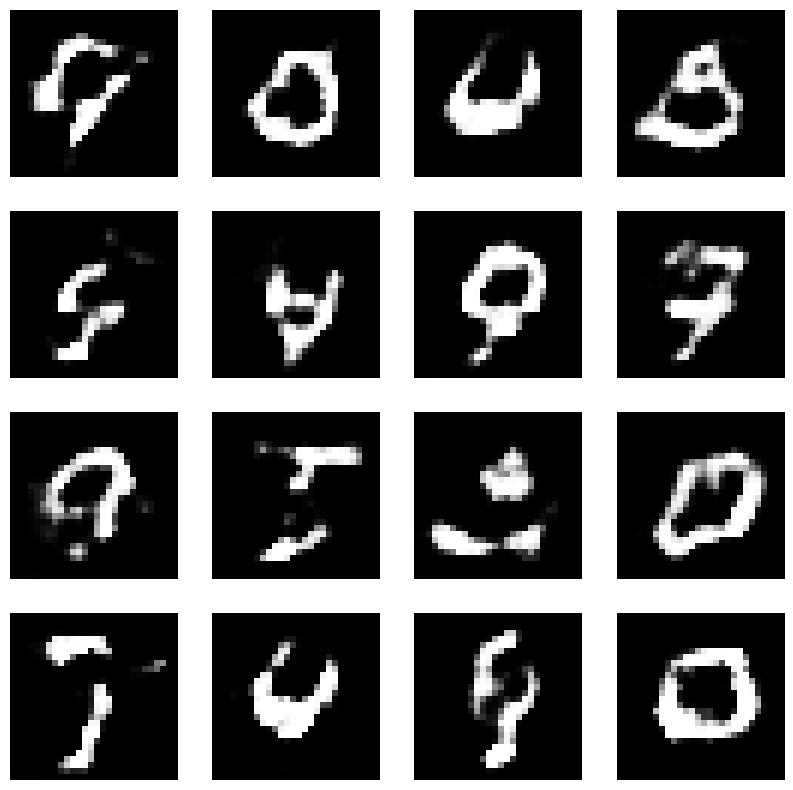

Época:  59


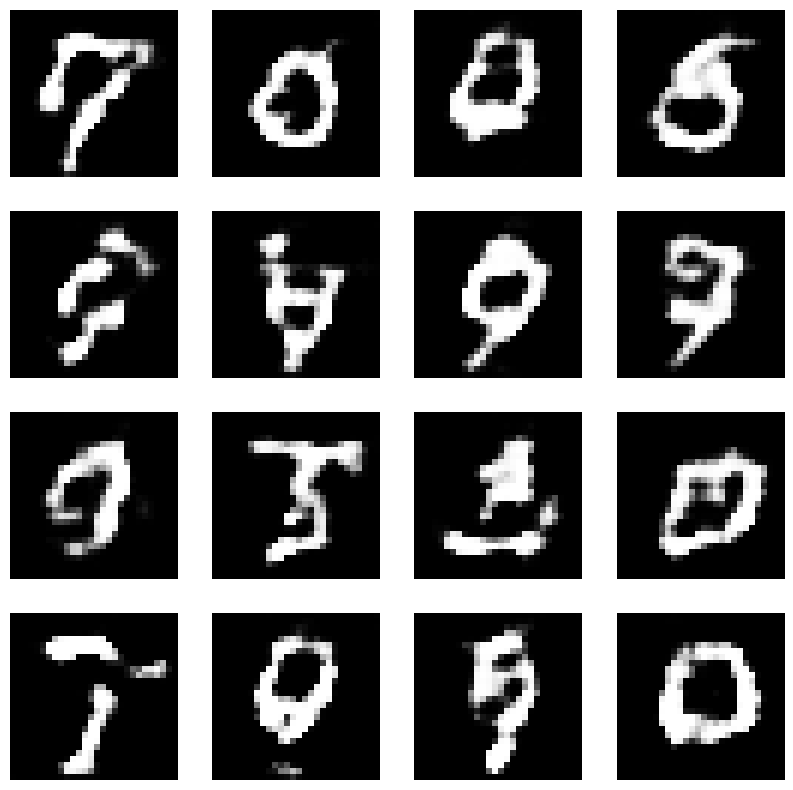

Época:  60


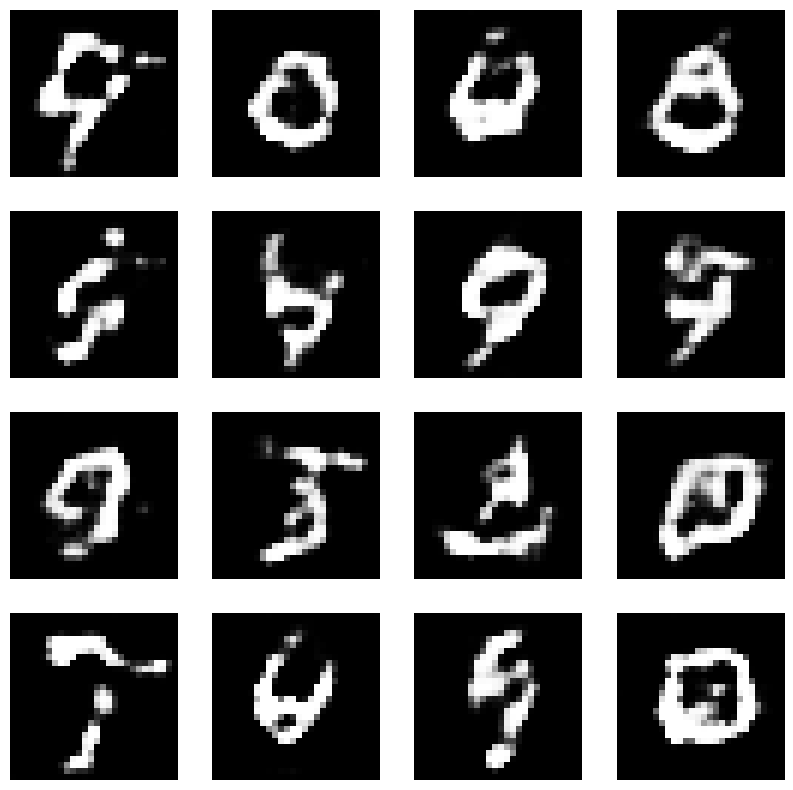

Época:  61


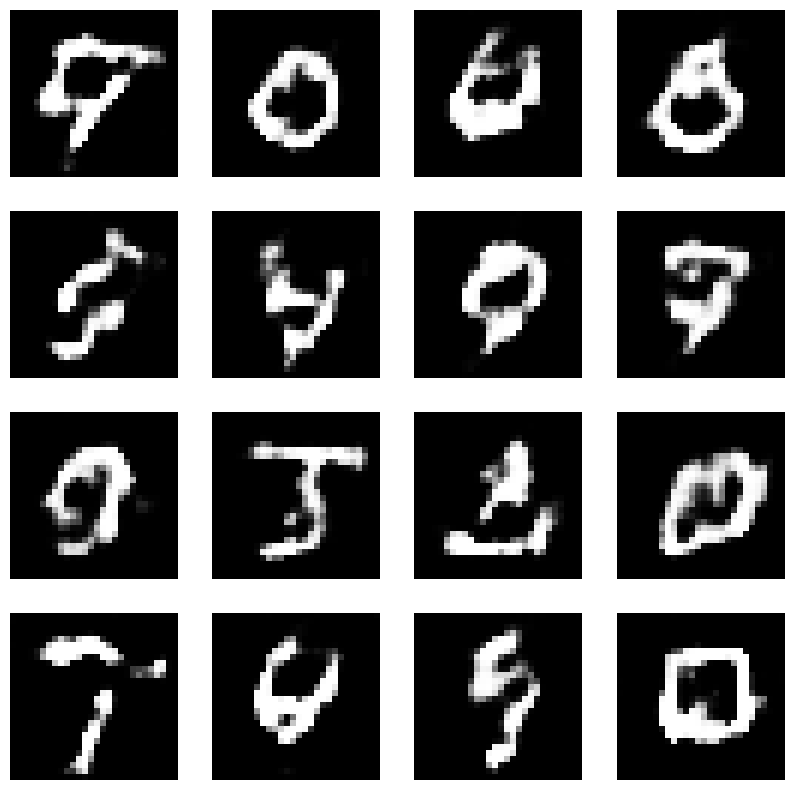

Época:  62


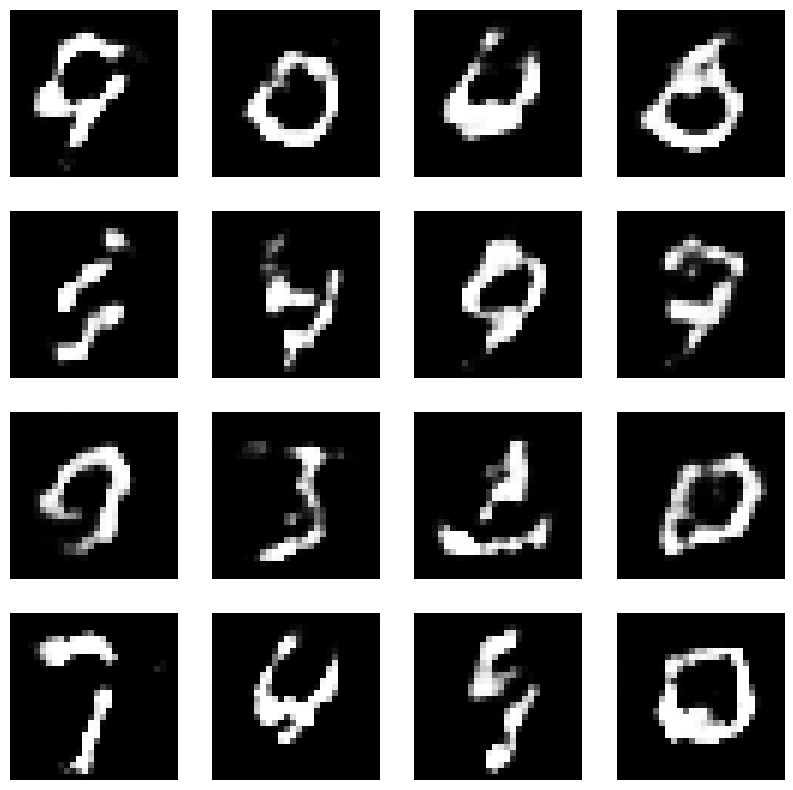

Época:  63


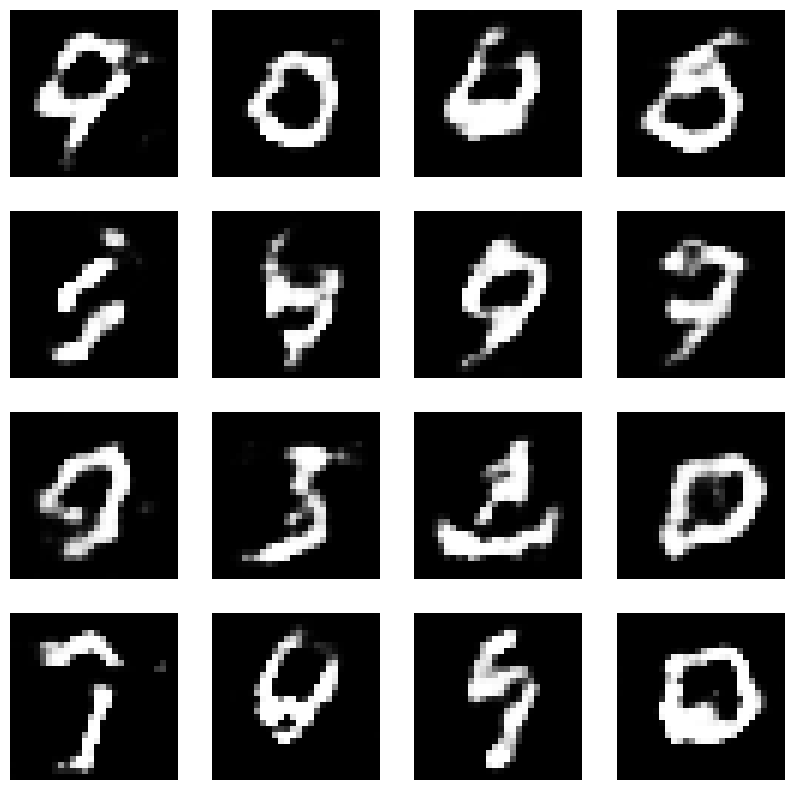

Época:  64


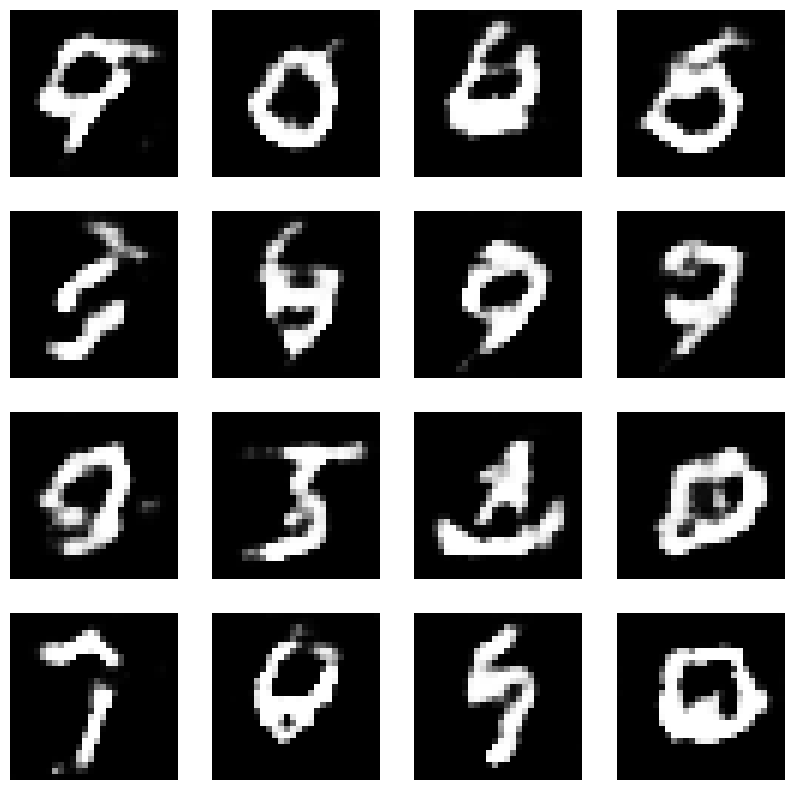

Época:  65


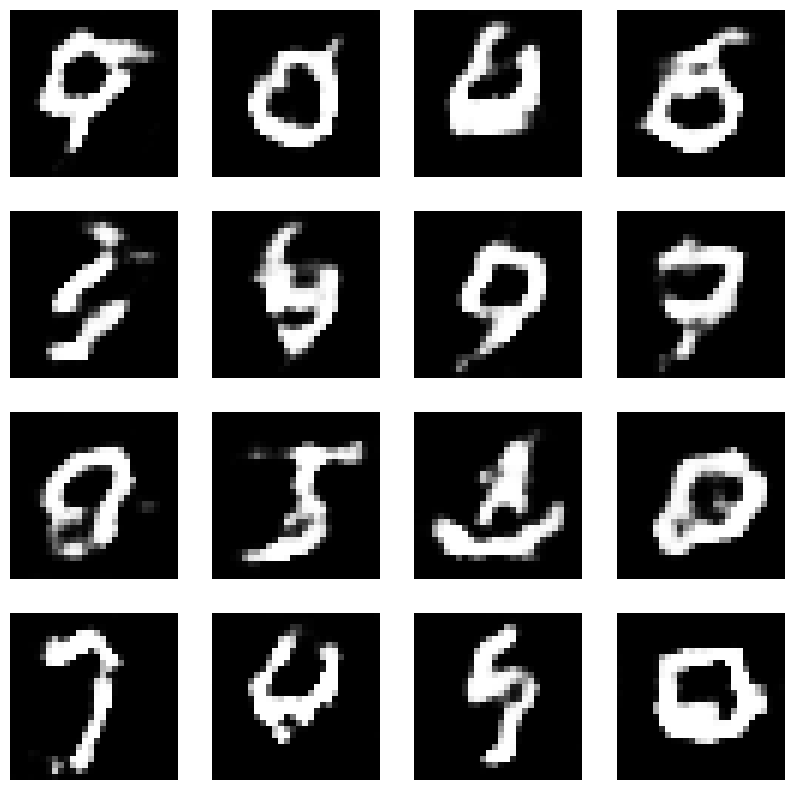

Época:  66


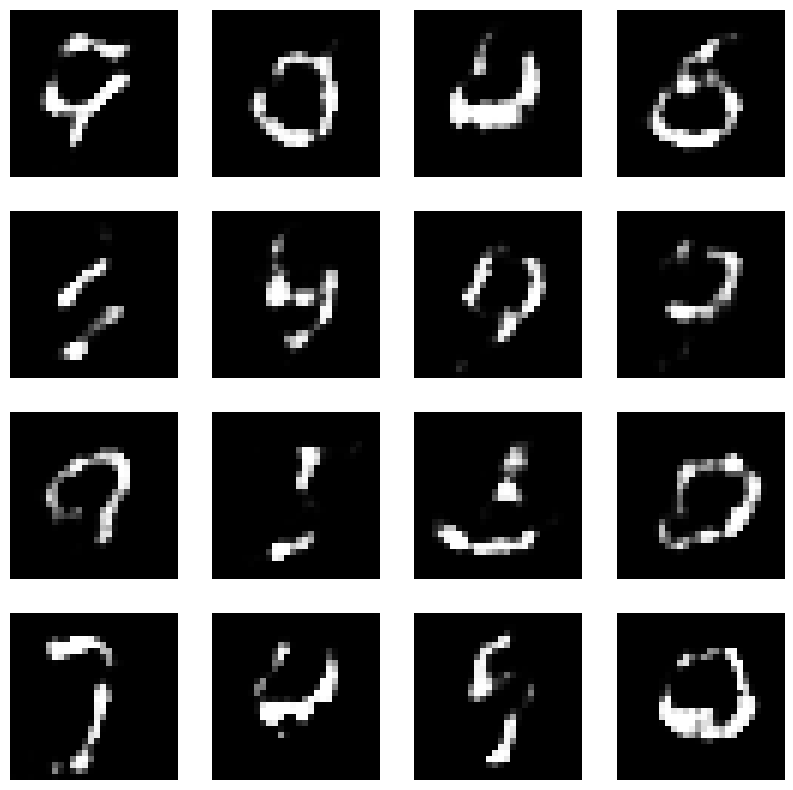

Época:  67


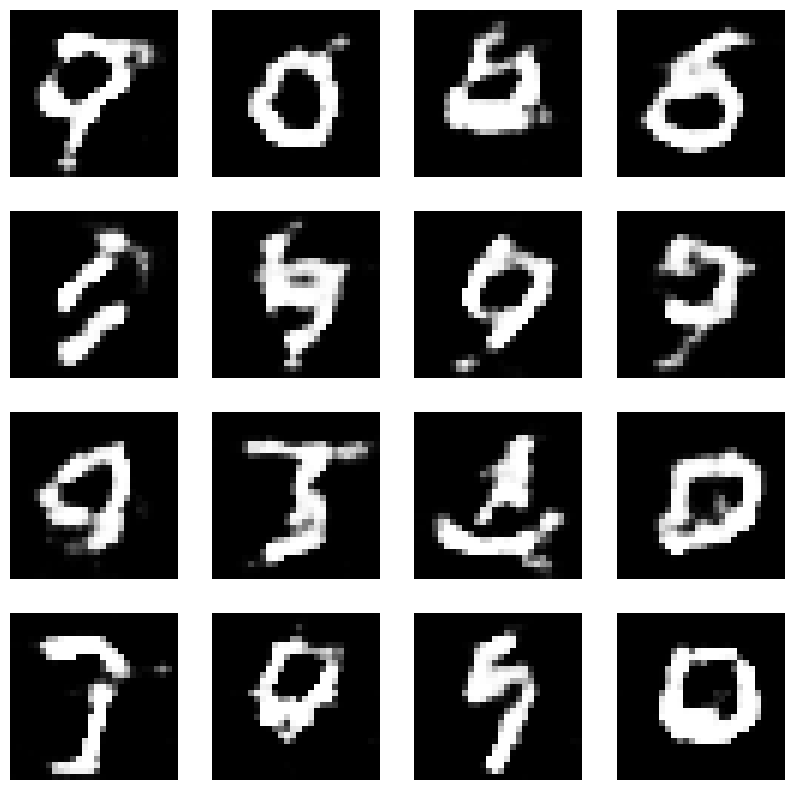

Época:  68


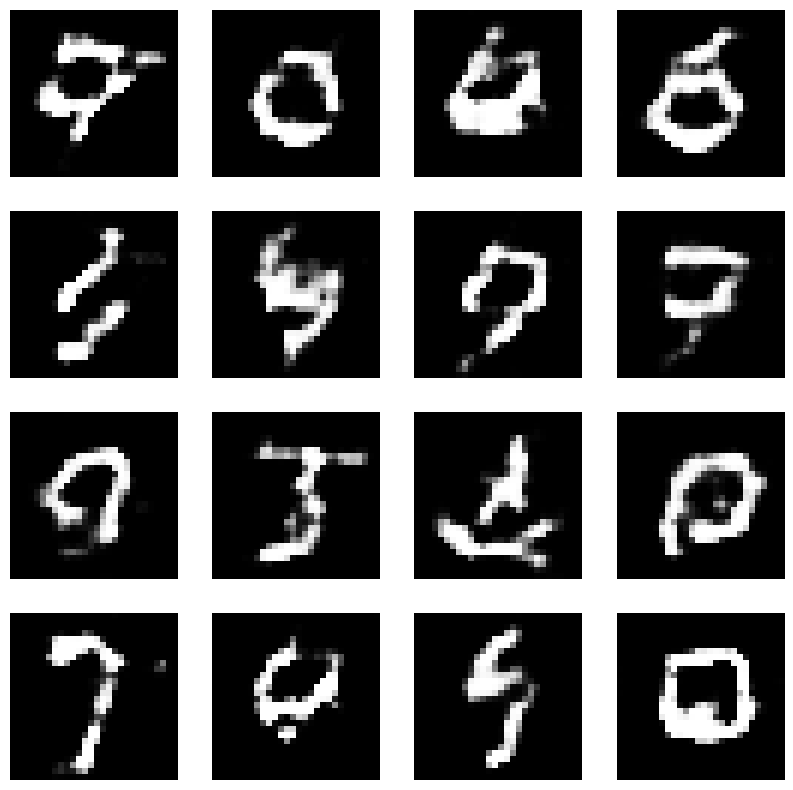

Época:  69


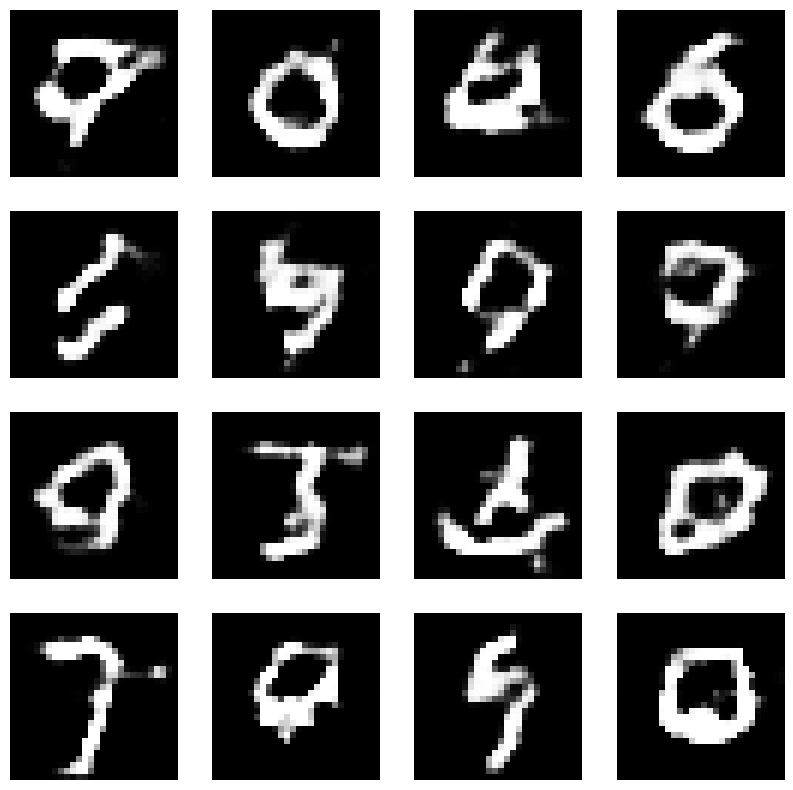

Época:  70


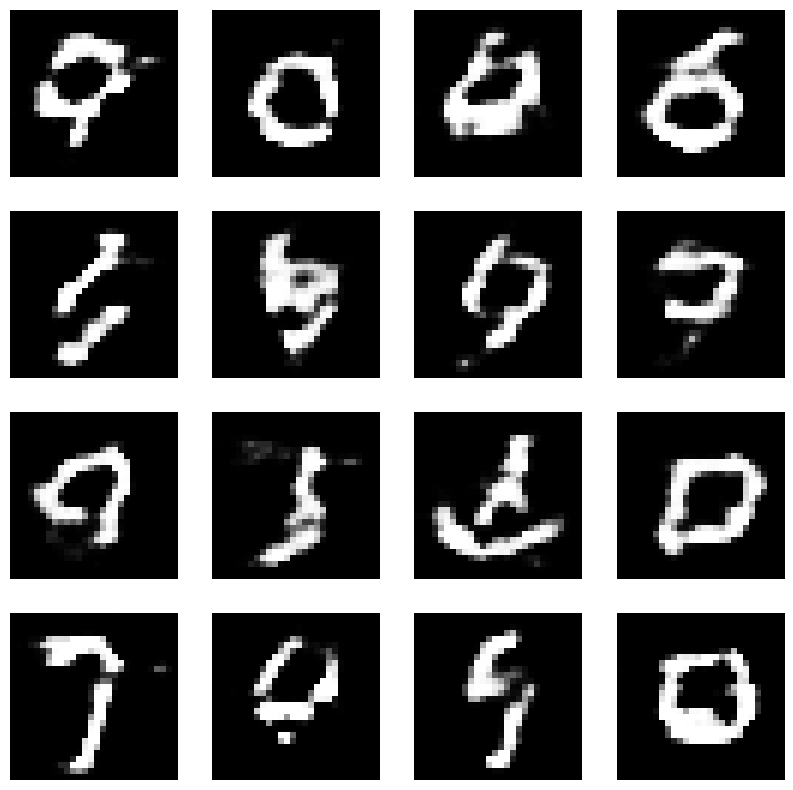

Época:  71


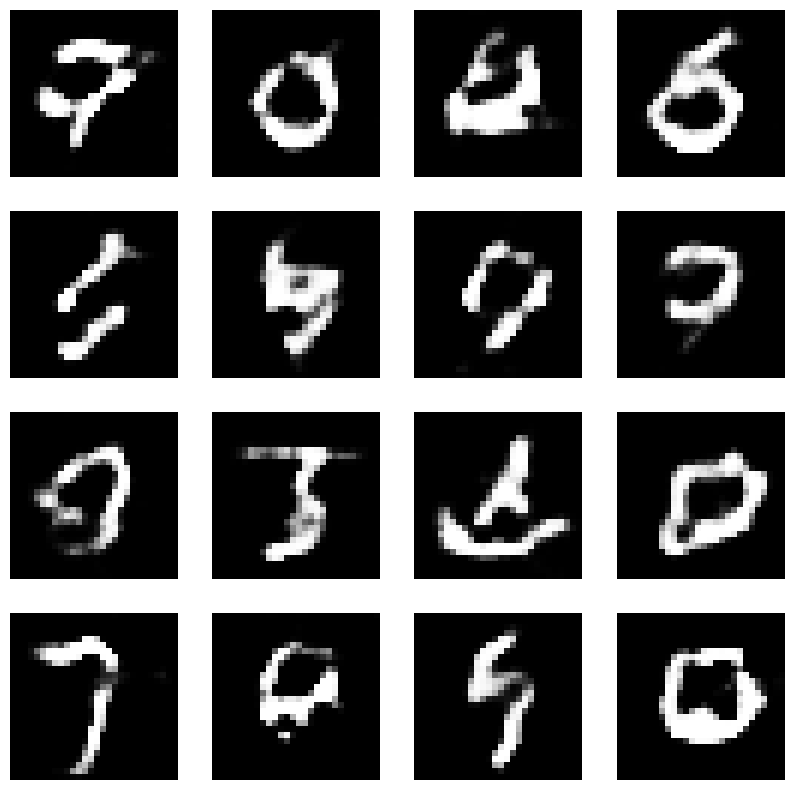

Época:  72


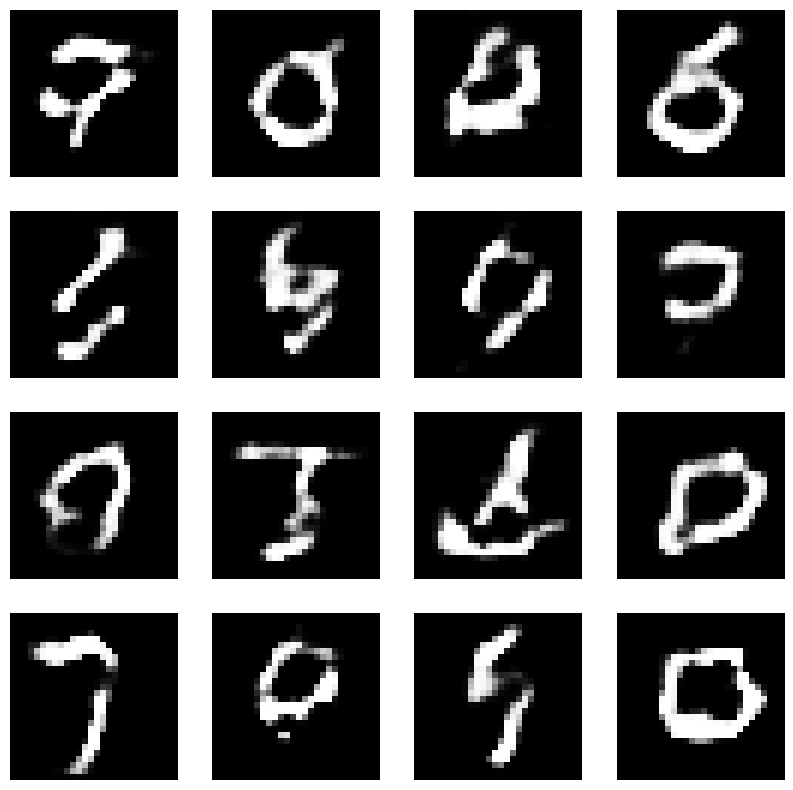

Época:  73


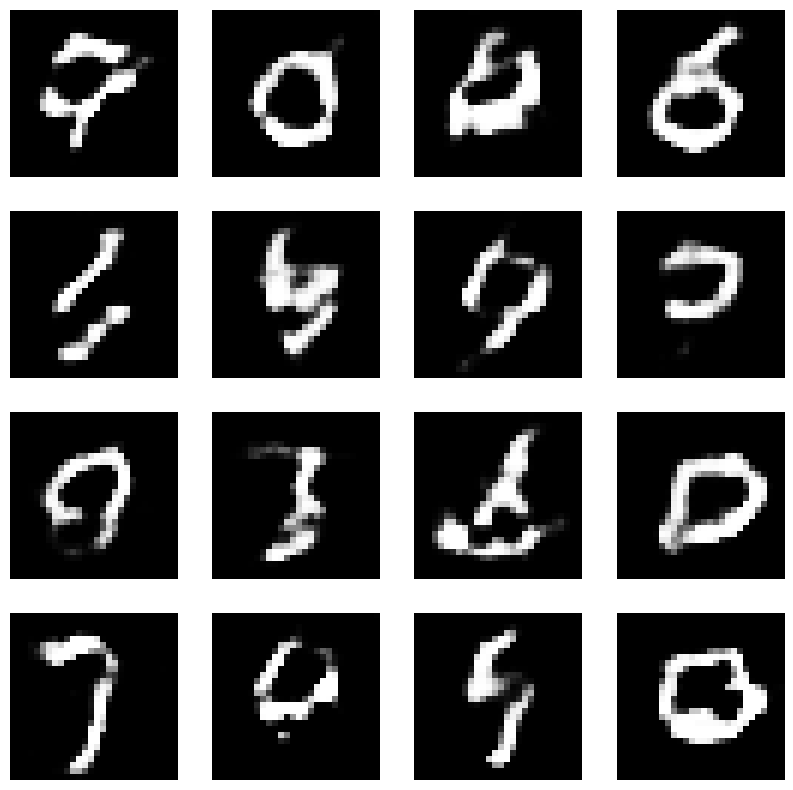

Época:  74


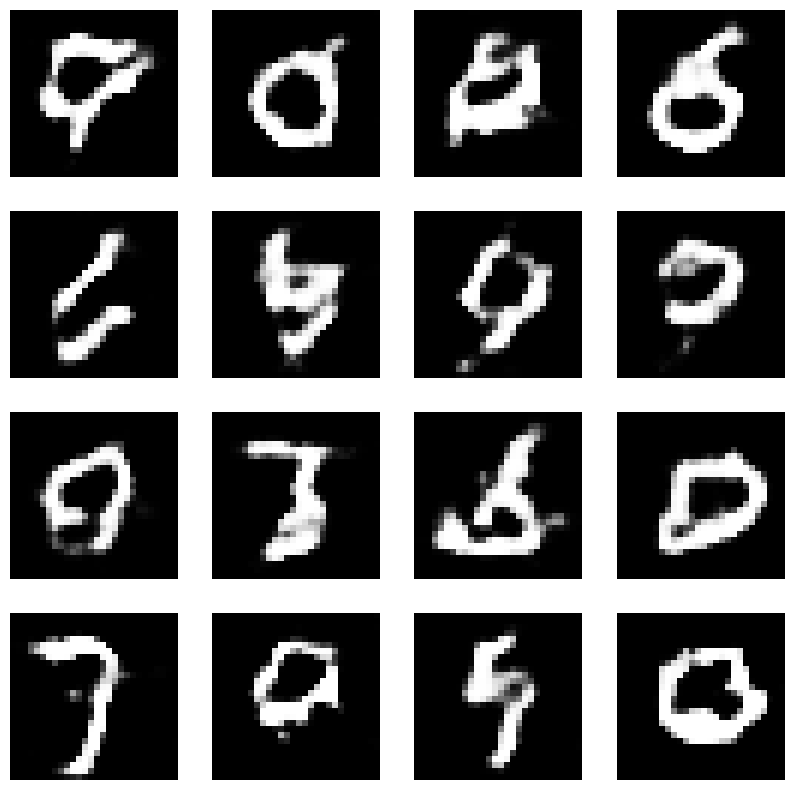

Época:  75


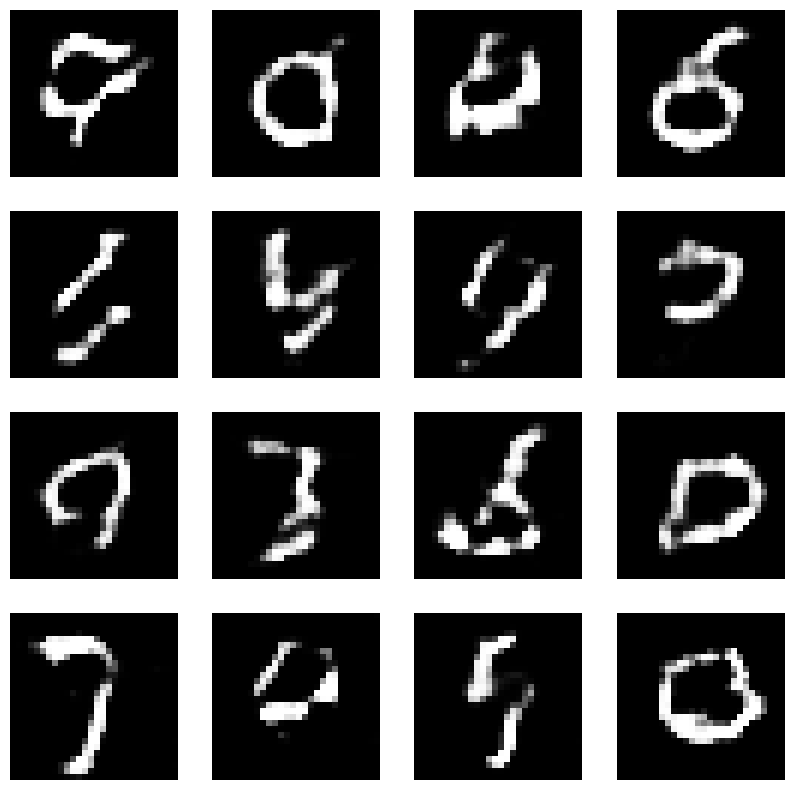

Época:  76


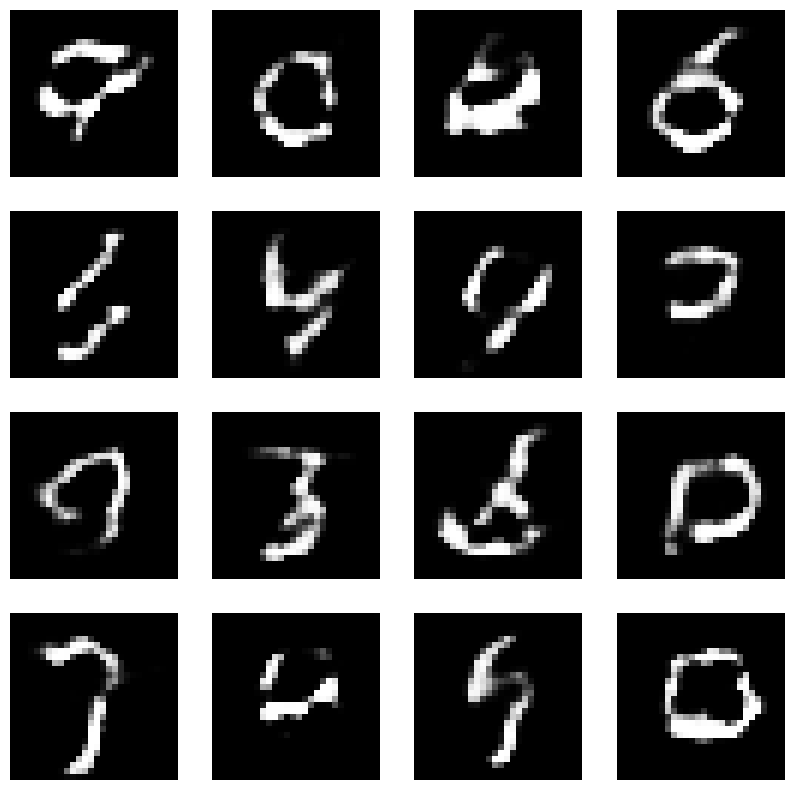

Época:  77


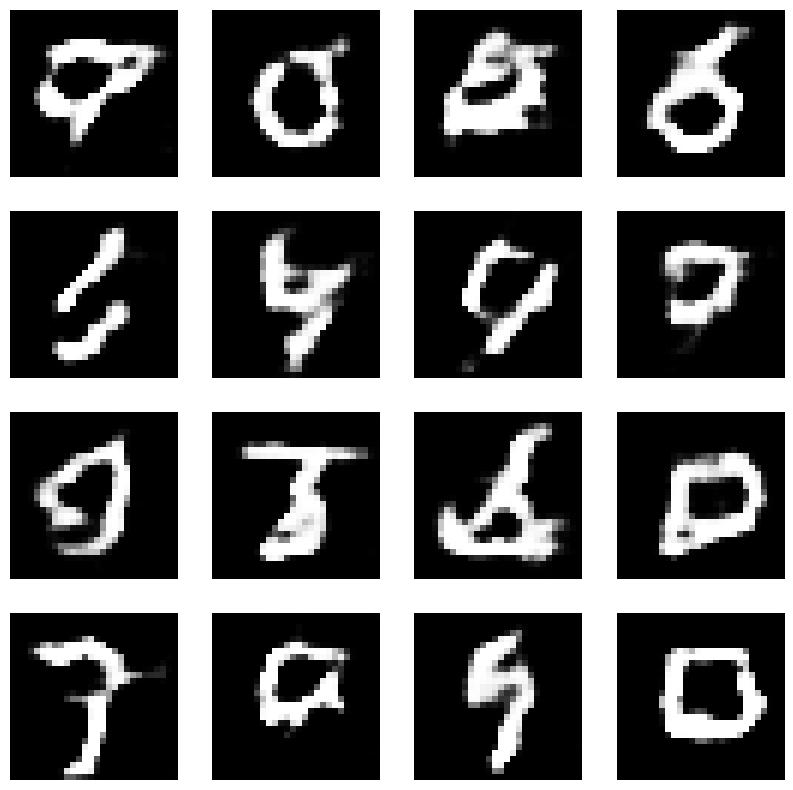

Época:  78


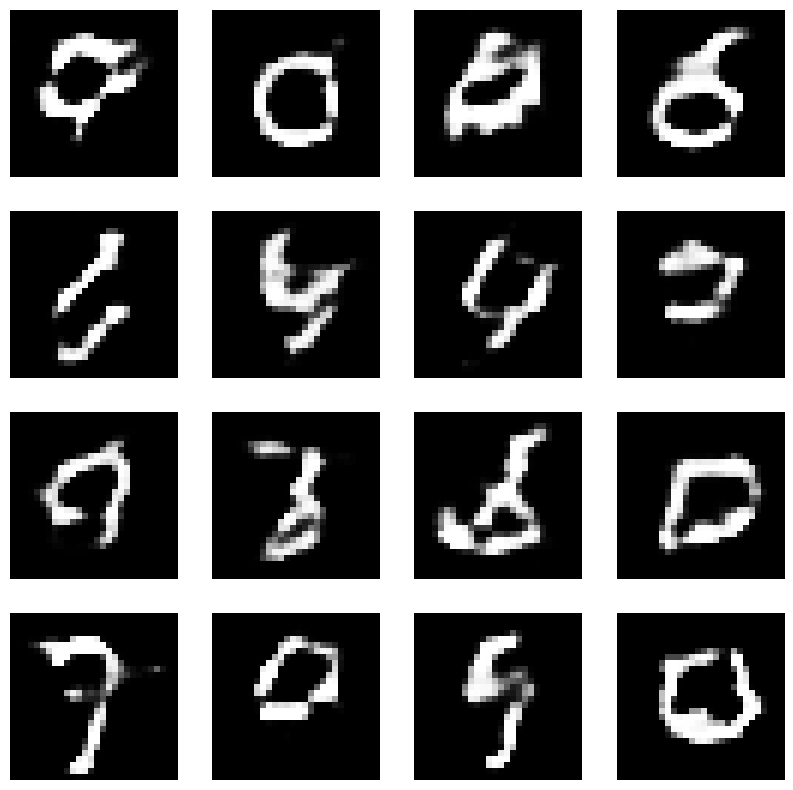

Época:  79


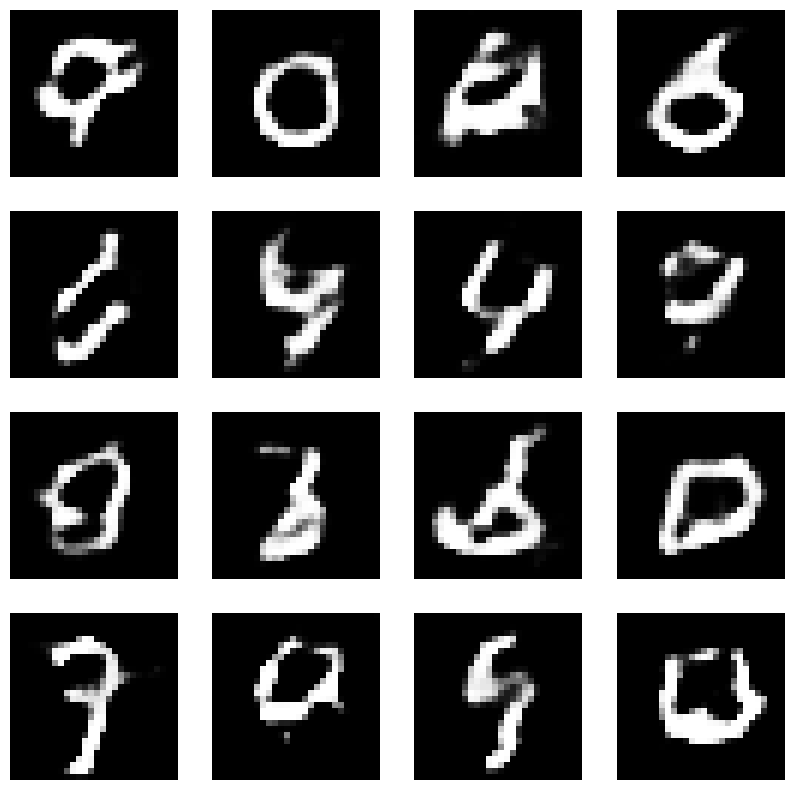

Época:  80


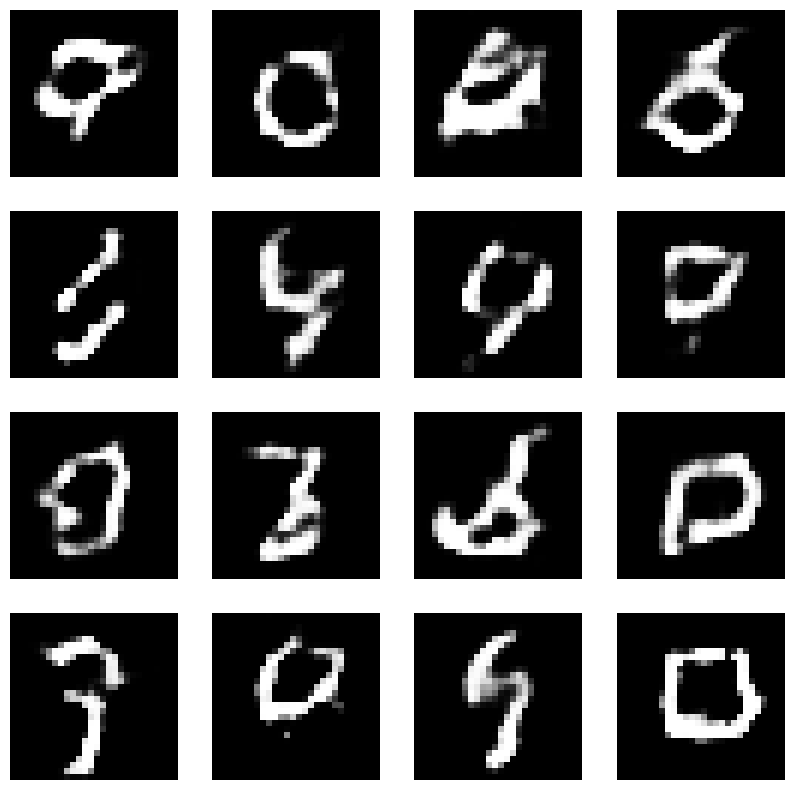

Época:  81


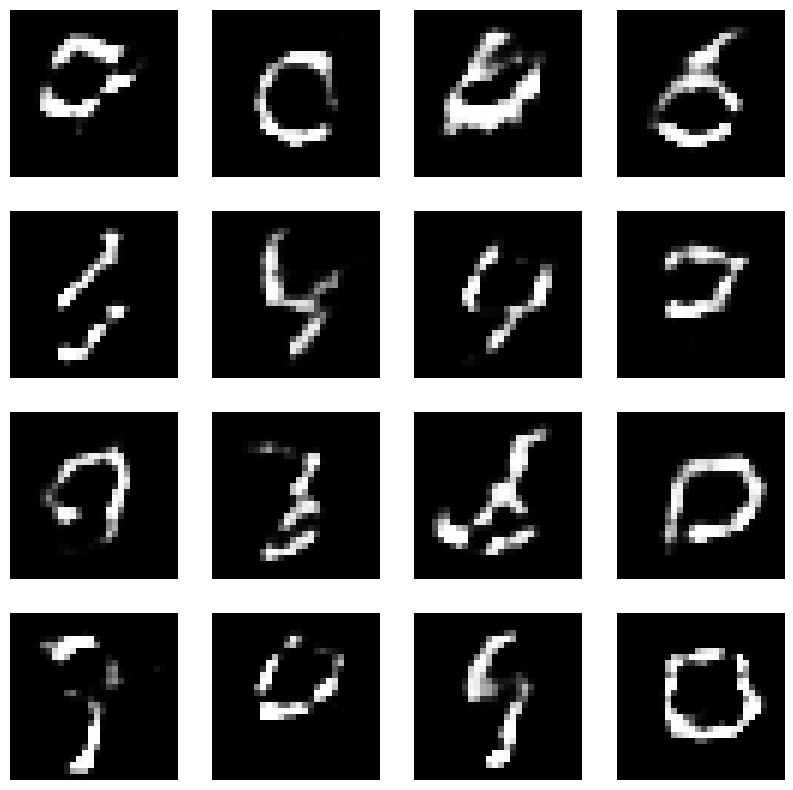

Época:  82


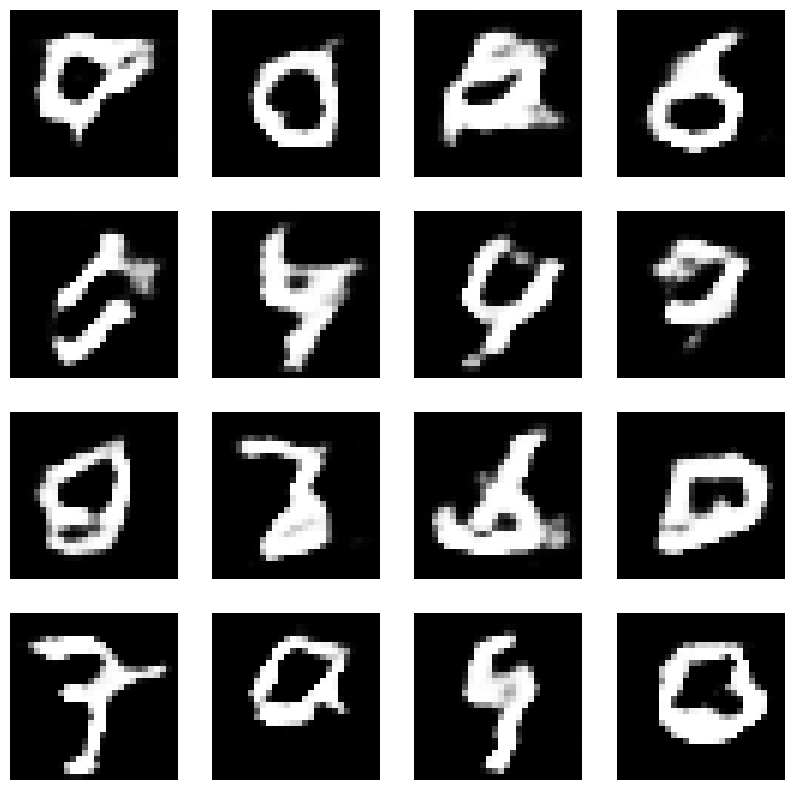

Época:  83


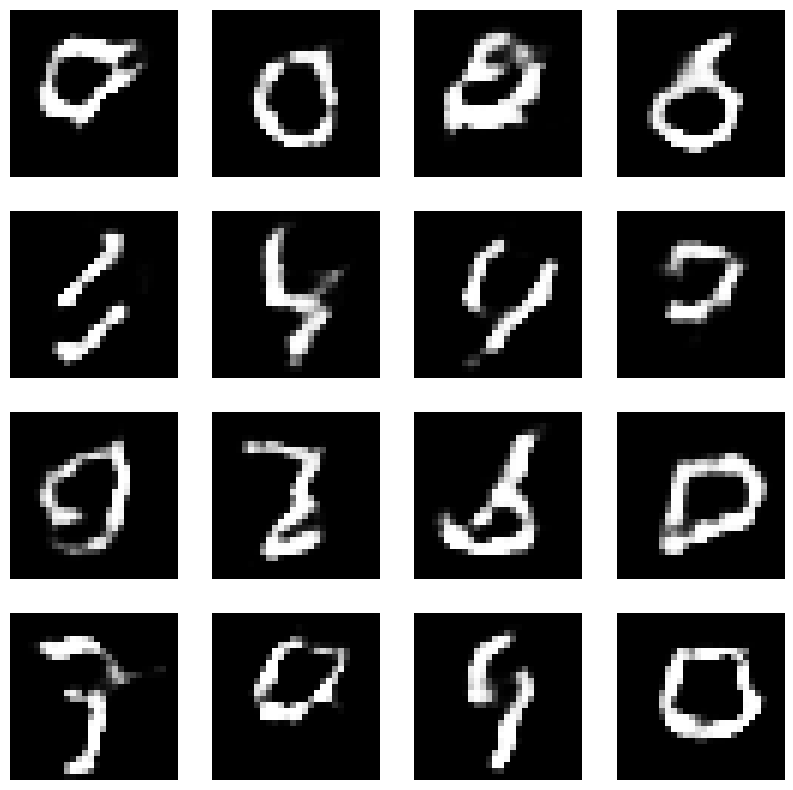

Época:  84


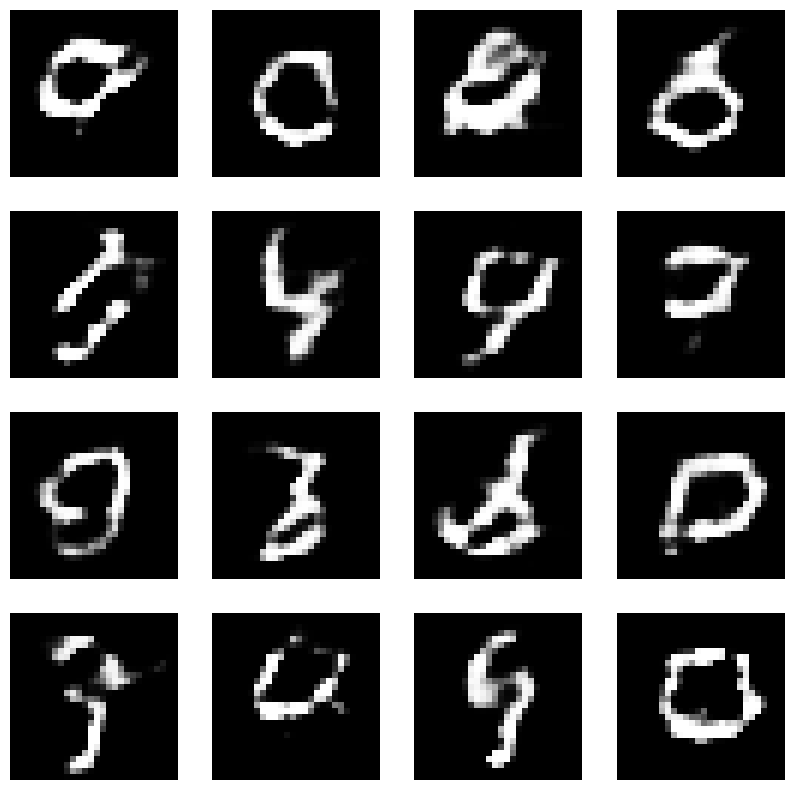

Época:  85


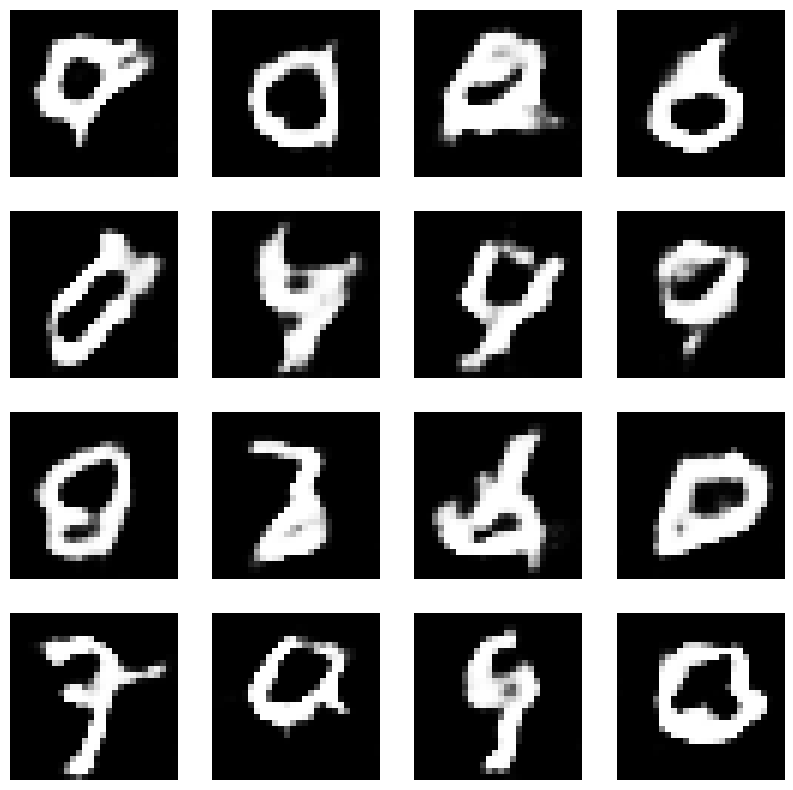

Época:  86


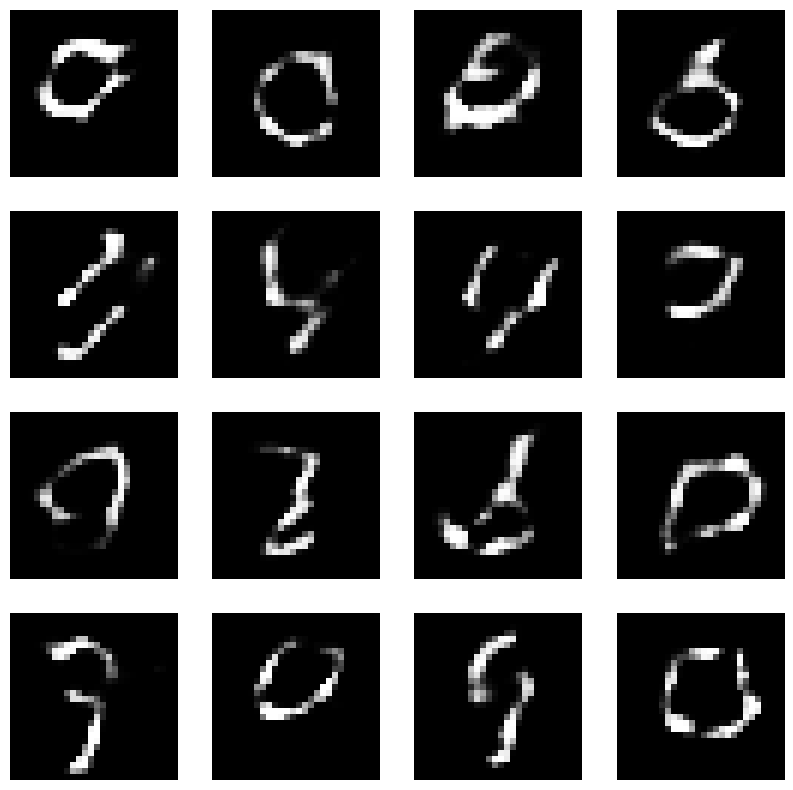

Época:  87


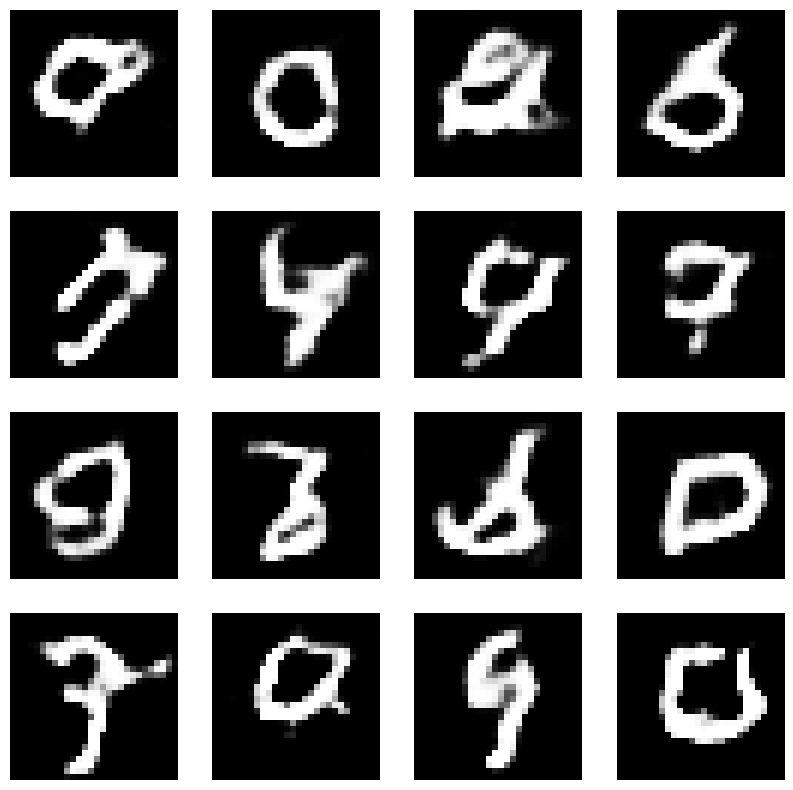

Época:  88


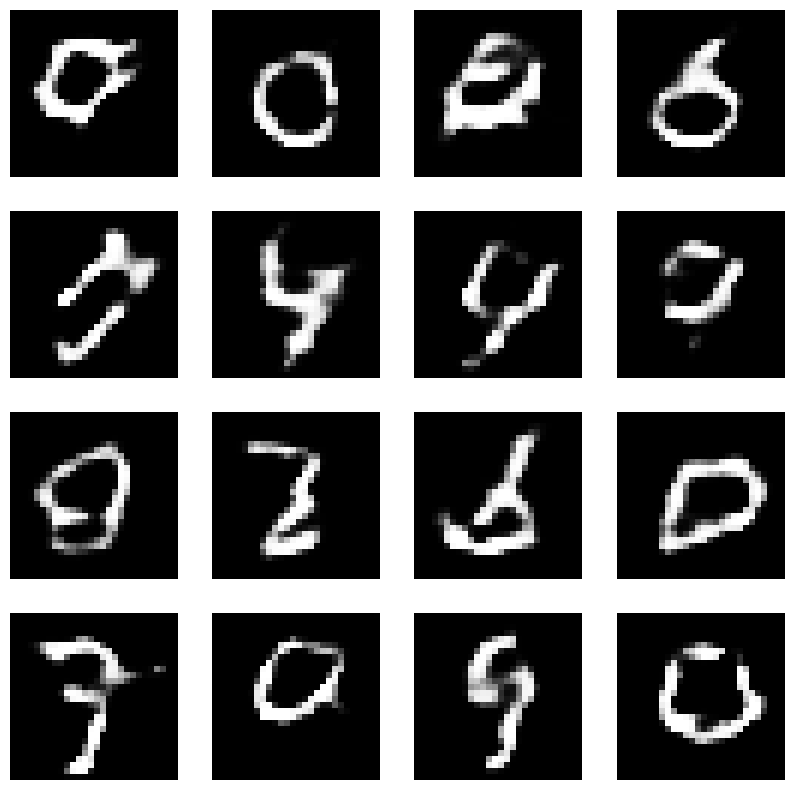

Época:  89


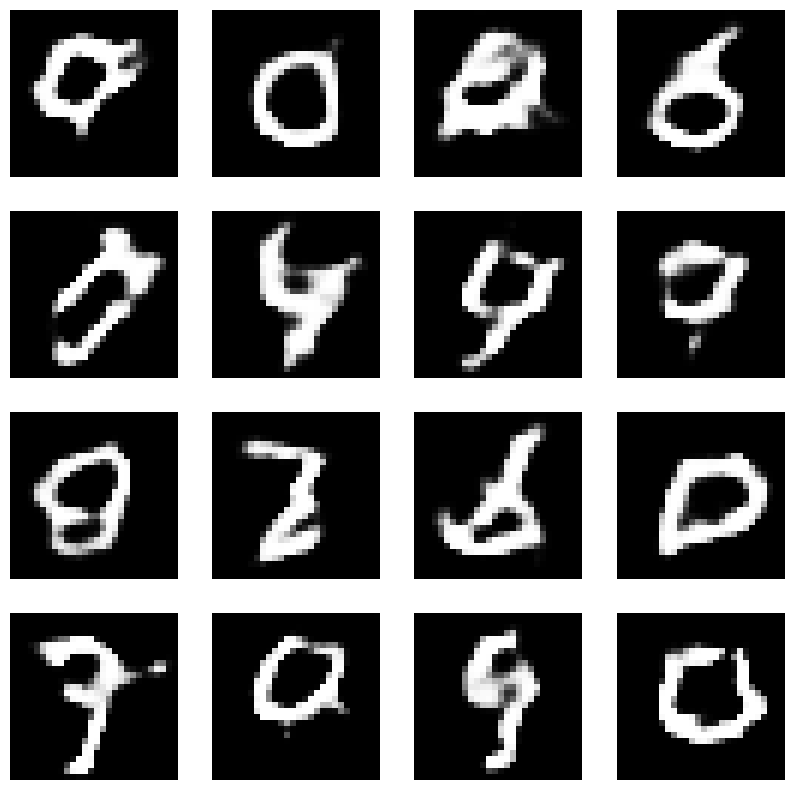

Época:  90


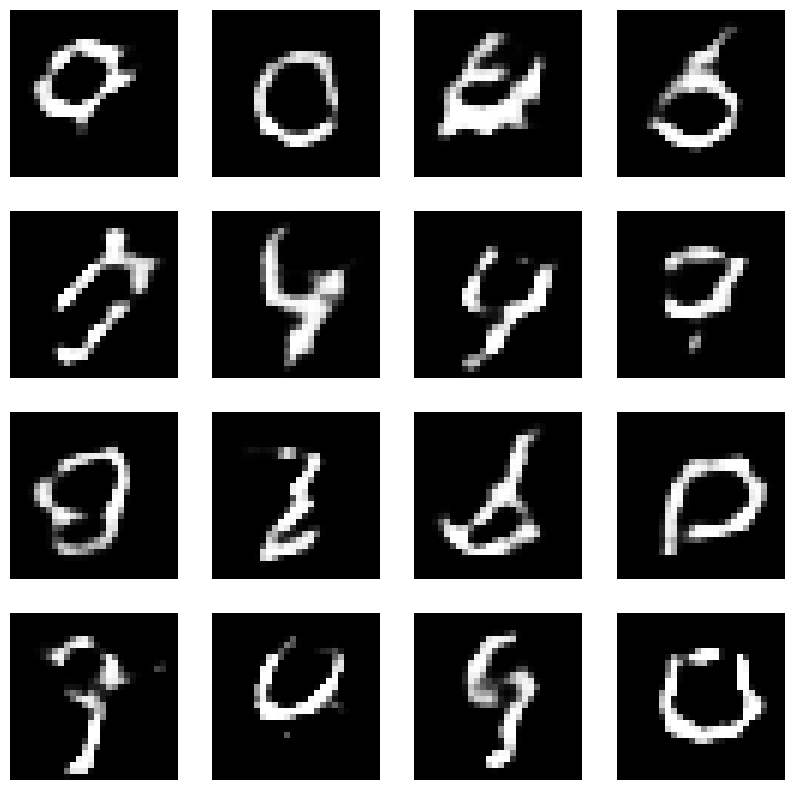

Época:  91


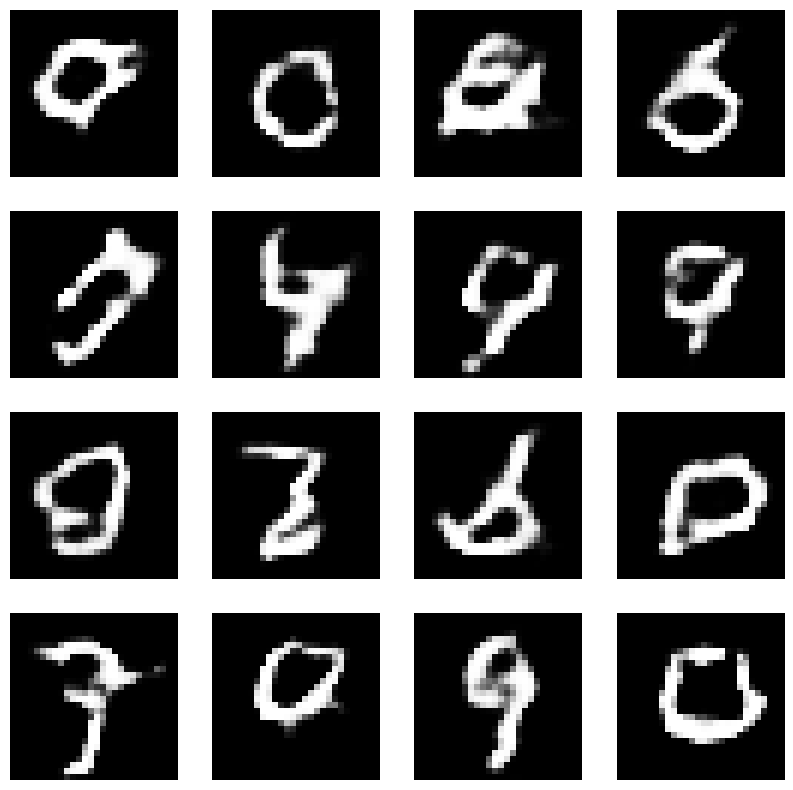

Época:  92


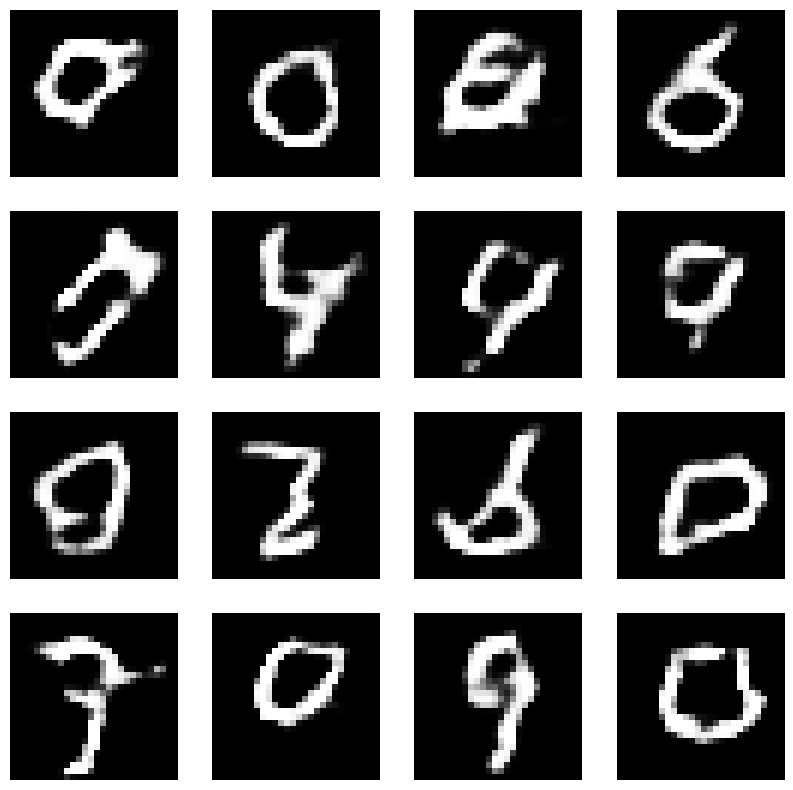

Época:  93


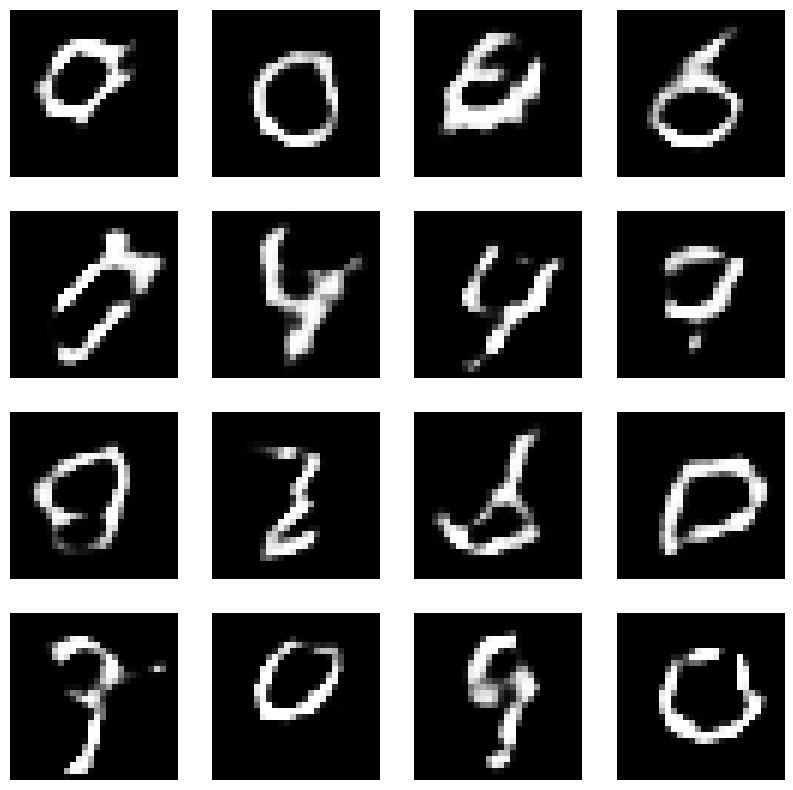

Época:  94


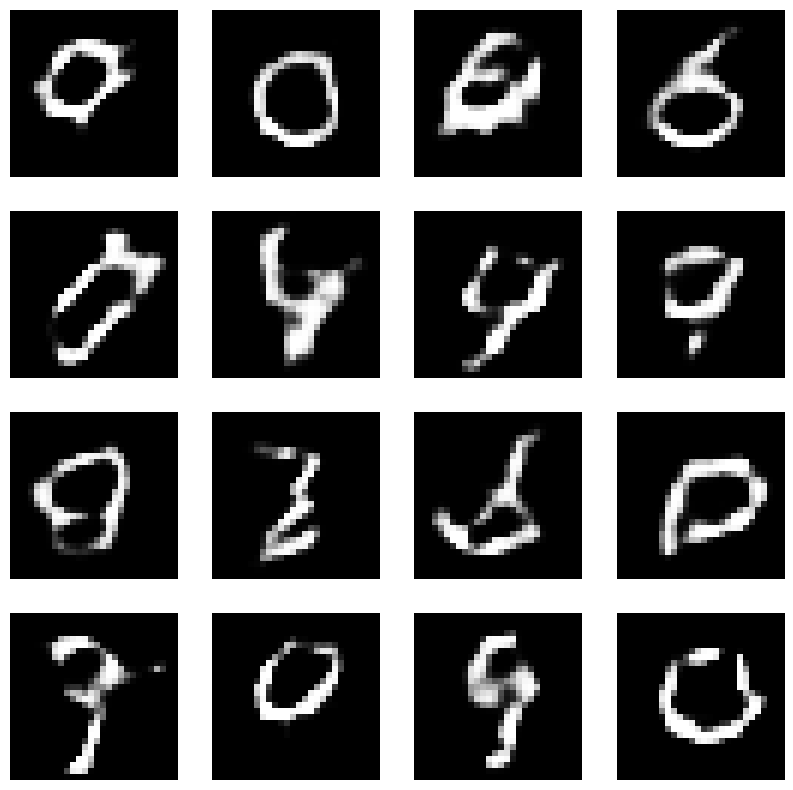

Época:  95


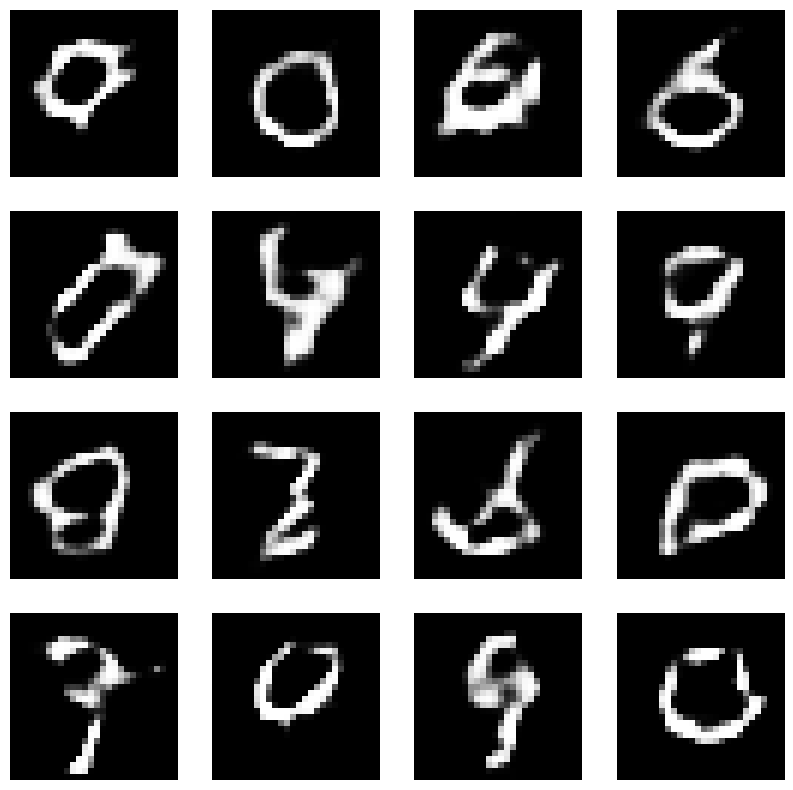

Época:  96


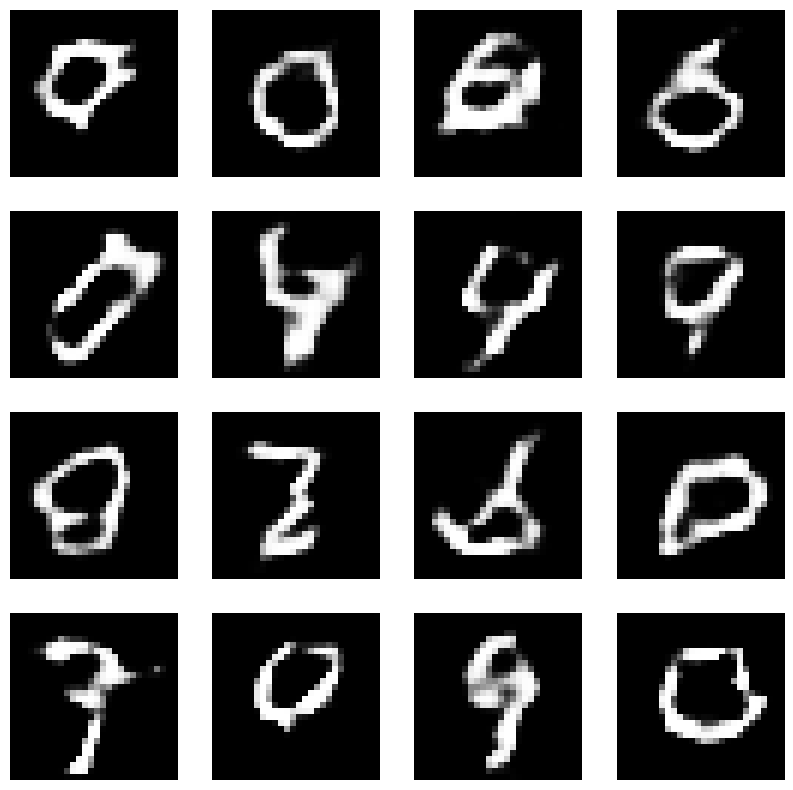

Época:  97


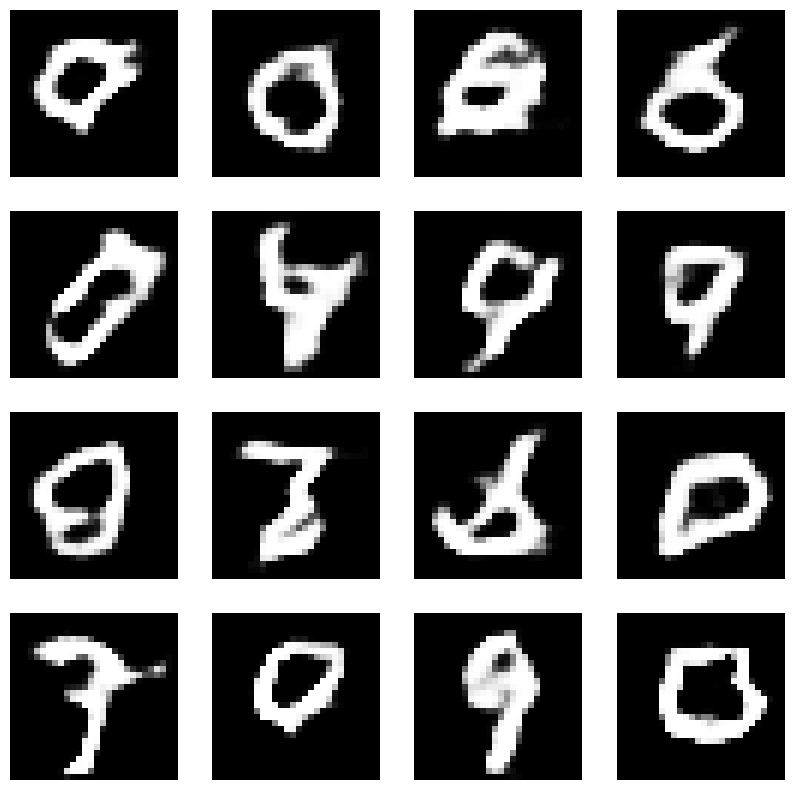

Época:  98


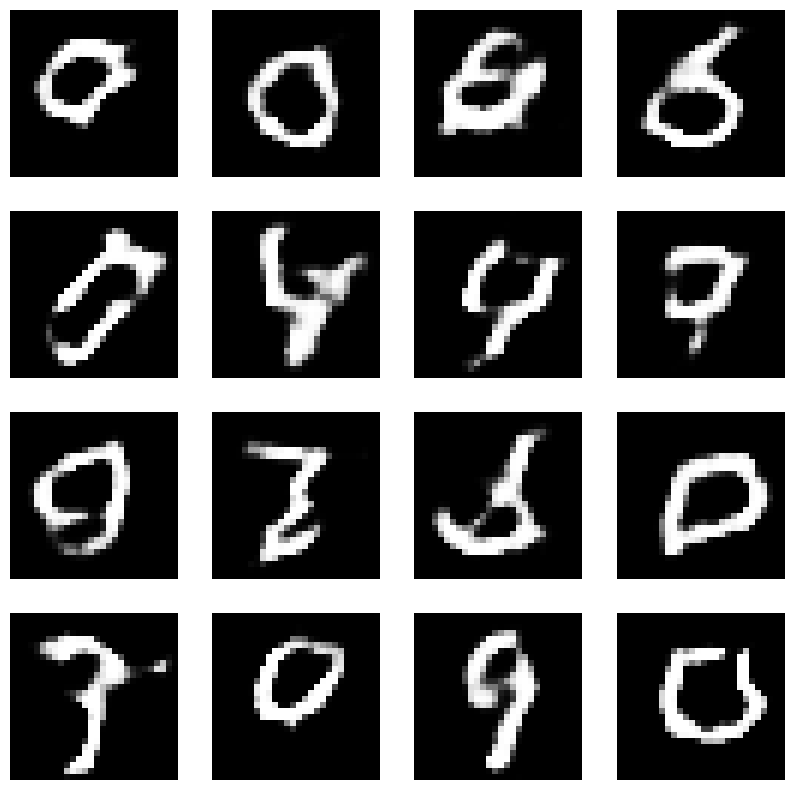

Época:  99


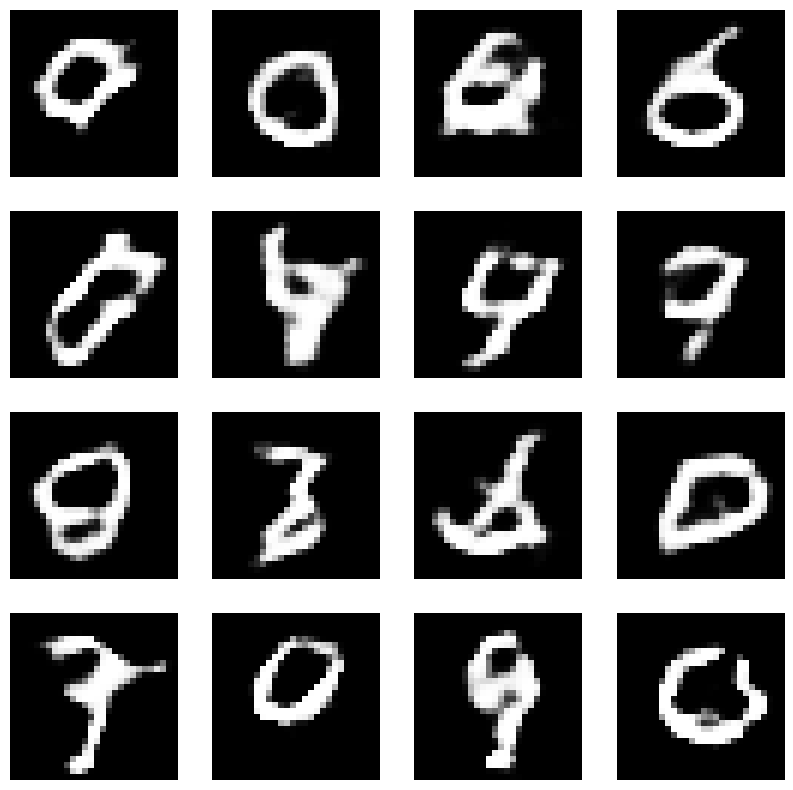

Época:  100


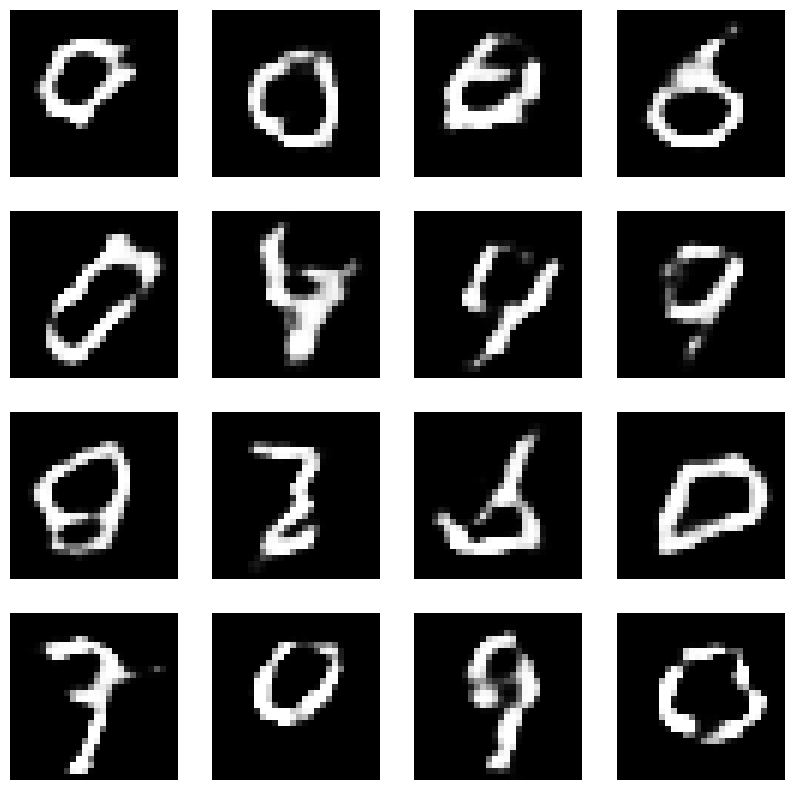

In [39]:
treina_gan(X_treinamento, epocas, imagens_teste)